In [1]:
# %%
import xarray as xr
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import itertools
from datetime import datetime

import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

import ML_functions
import ML_Models
from ML_functions import HydroDataset
from ML_Losses import KGELoss, NSELoss

import torch
import torch.nn as nn
import random

# Intuition Plots

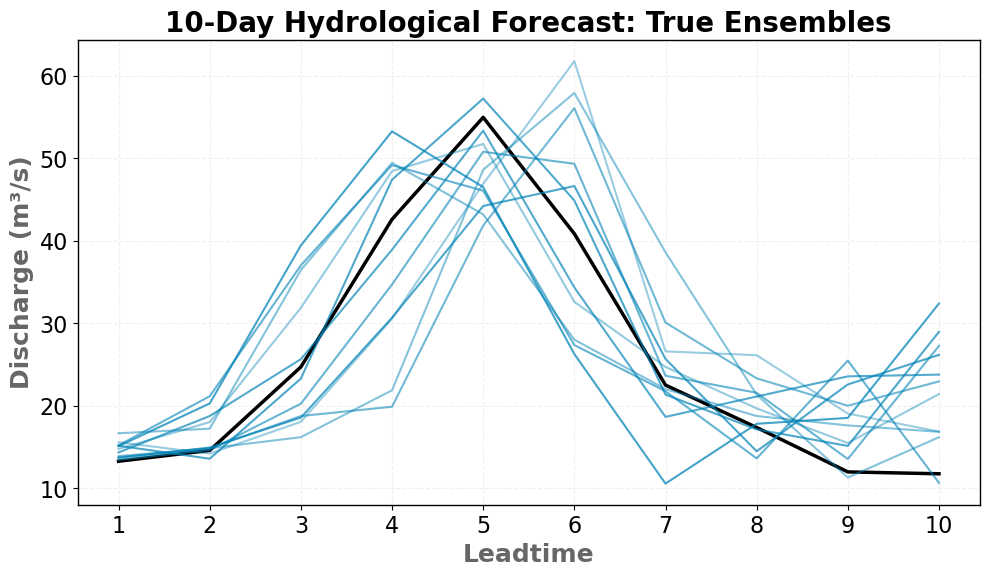

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
from matplotlib.patches import Patch
import matplotlib as mpl
import random

# Set the seed for reproducibility
np.random.seed(42)

# Create date range for the 10-day hydrograph
# start_date = datetime(2025, 4, 20)  # Start date
# dates = [start_date + timedelta(days=i) for i in range(10)]

leadtime = np.arange(1, 11)

# Generate realistic streamflow data (in cubic meters per second)
# Base flow with some seasonal pattern
base_flow = 15 + 5 * np.sin(np.linspace(0, np.pi/4, 10))

# Create forecast data (center of the ensemble)
forecast_flow = base_flow.copy()
peak_position = 4
peak_height = 40
peak_width = 1.5
for i in range(10):
    forecast_flow[i] += peak_height * np.exp(-((i - peak_position) / peak_width) ** 2)

# Add some small random variations to the forecast
forecast_flow += np.random.normal(0, 1.5, 10)

# Create actual flow that will be within uncertainty bounds
# Using the same base pattern but with some variation
observed_flow = forecast_flow.copy()
# Shift the peak slightly and modify height within expected range
observed_shift = 0.2
observed_scale = 0.9  # Scale down slightly but still within bounds
for i in range(10):
    # Start with forecast and apply a transformation that keeps it mostly within bounds
    observed_flow[i] = forecast_flow[i] * (observed_scale + 0.15 * np.sin(i/2))

# Add slight random variations to make it look natural but still mostly within bounds
observed_flow += np.random.normal(0, 2, 10)

# Ensure no negative values
observed_flow = np.maximum(observed_flow, 0.5)
forecast_flow = np.maximum(forecast_flow, 0.5)

# Generate ensemble members with varying peak timing
n_ensemble = 11
ensemble_members = []
spread_factor = 4.5  # Spread factor for amplitude uncertainty

# Define the peak position and its uncertainty range
peak_position = 4
peak_timing_spread = 1  # Days of uncertainty in peak timing

for i in range(n_ensemble):
    # Create a unique member with shifted peak timing
    member = base_flow.copy()
    
    # Randomize peak timing for this ensemble member
    member_peak_position = peak_position + np.random.uniform(-peak_timing_spread, peak_timing_spread)
    peak_height_factor = np.random.uniform(0.8, 1.2)  # Allow some variation in peak height
    
    # Apply the peak with shifted timing for this member
    for j in range(10):
        member[j] += peak_height * peak_height_factor * np.exp(-((j - member_peak_position) / peak_width) ** 2)
    
    # Add increasing uncertainty with lead time
    uncertainty = np.linspace(0.7, 2.5, 10)
    member += np.random.normal(0, spread_factor/2, 10) * uncertainty  # Reduced noise since timing variation adds spread
    
    ensemble_members.append(np.maximum(member, 0.2))  # Ensure positive values

# Calculate ensemble statistics
ensemble_array = np.array(ensemble_members)
ensemble_mean = np.mean(ensemble_array, axis=0)
ensemble_median = np.median(ensemble_array, axis=0)
ensemble_min = np.min(ensemble_array, axis=0)
ensemble_max = np.max(ensemble_array, axis=0)
ensemble_25 = np.percentile(ensemble_array, 25, axis=0)
ensemble_75 = np.percentile(ensemble_array, 75, axis=0)
ensemble_10 = np.percentile(ensemble_array, 10, axis=0)
ensemble_90 = np.percentile(ensemble_array, 90, axis=0)

# Create a figure with ECMWF style
plt.figure(figsize=(10, 6))

# Set up the style to match ECMWF graphics
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# Define ECMWF-like colors
ecmwf_blue = '#0082B6'  # Main ECMWF blue
ecmwf_gray = '#666666'  # For grid and labels
ensemble_blue = '#A6CEE3'  # Lighter blue for ensemble spread

# Plot ensemble ranges (shaded areas for uncertainty)
# plt.fill_between(dates, ensemble_min, ensemble_max, color=ensemble_blue, alpha=0.2, label='Min-Max Range')
# plt.fill_between(dates, ensemble_10, ensemble_90, color=ensemble_blue, alpha=0.3, label='10-90th Percentile')
# plt.fill_between(dates, ensemble_25, ensemble_75, color=ensemble_blue, alpha=0.5, label='25-75th Percentile')

# Plot the forecast mean as a dashed line
# plt.plot(dates, ensemble_mean, '--', color=ecmwf_blue, linewidth=2, label='Ensemble Mean')

# Plot the forecast median as a solid line
# plt.plot(dates, ensemble_median, '-', color=ecmwf_blue, linewidth=2.5, label='Forecast')

# Plot the actual flow with a black line across all 10 days
plt.plot(leadtime, observed_flow, '-', color='black', linewidth=2.5, label='Actual Flow')

# Add individual ensemble members with low opacity
for member in ensemble_members:
    random_alpha = random.uniform(0.3, 0.8)
    plt.plot(leadtime, member, '-', color=ecmwf_blue, linewidth=1.5, alpha=random_alpha)

# Set up the x-axis with proper date formatting
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Customize the appearance
plt.xticks(leadtime, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, which='major', axis='both', linestyle='--', color='#CCCCCC')
plt.xlabel('Leadtime', fontweight='bold', fontsize=18, color=ecmwf_gray)
plt.ylabel('Discharge (m³/s)', fontweight='bold', fontsize=18, color=ecmwf_gray)
plt.title('10-Day Hydrological Forecast: True Ensembles', fontweight='bold', fontsize=20)

# Add legend with ECMWF style
legend_elements = [
    Patch(facecolor=ensemble_blue, alpha=0.2, edgecolor='none', label='Min-Max Range'),
    Patch(facecolor=ensemble_blue, alpha=0.3, edgecolor='none', label='10-90th Percentile'),
    Patch(facecolor=ensemble_blue, alpha=0.5, edgecolor='blue', label='Ensemble Member'),
    plt.Line2D([0], [0], color=ecmwf_blue, linestyle='--', lw=2, label='Ensemble Mean'),
    plt.Line2D([0], [0], color=ecmwf_blue, lw=2.5, label='Forecast'),
    plt.Line2D([0], [0], color='black', lw=2.5, label='Actual Flow')
]
# plt.legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.9, edgecolor='#CCCCCC')

# Add annotation for peak flow
# peak_day = dates[peak_position]
# peak_value = observed_flow[peak_position]
# plt.annotate(f'Peak: {peak_value:.1f} m³/s',
#              xy=(peak_day, peak_value),
#              xytext=(5, 10), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', color=ecmwf_gray),
#              fontsize=9, color=ecmwf_gray, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

# Create a footer with ECMWF-like information
# plt.figtext(0.99, 0.01, 'Data: Simulated for demonstration', fontsize=8, ha='right', color=ecmwf_gray)

# Rotate x-axis labels and adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for date labels

# Show the plot
plt.show()

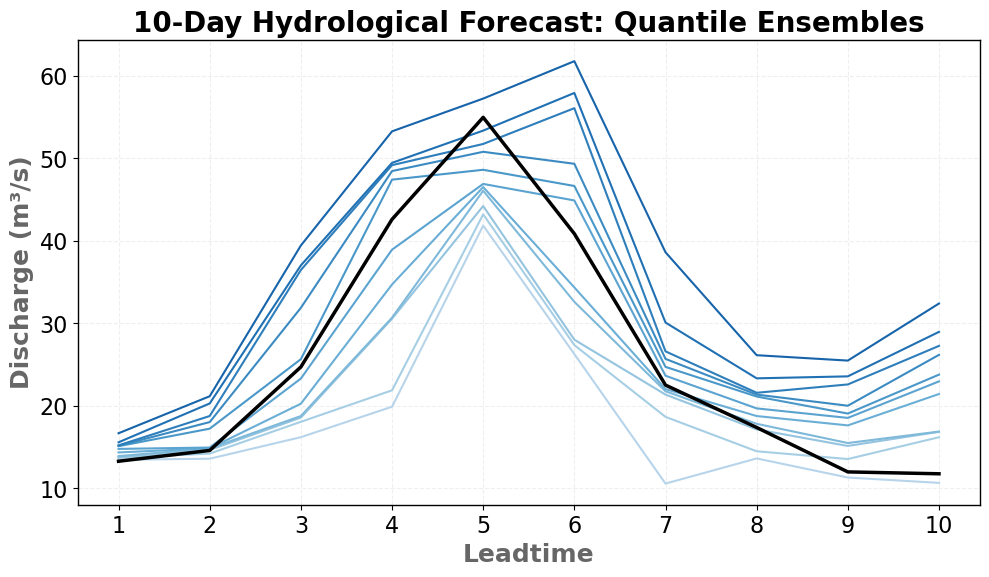

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta

# Set the seed for reproducibility
np.random.seed(42)

# --- 1. Create Date Range ---
n_leadtimes = 10
leadtime = np.arange(1, 11)

# --- 4. Plot the 11 Quantile Traces ---
plt.figure(figsize=(10, 6))

ensemble_array = np.array(ensemble_members)
sorted_traces = np.sort(ensemble_array, axis=0)

# Plot all 11 sorted traces
# Use a colormap to distinguish them (optional, but nice)
colors = plt.cm.Blues(np.linspace(0.3, 0.8, n_ensemble))
for i in range(n_ensemble):
    # The 'i'-th row is the i-th quantile trace
    plt.plot(leadtime, sorted_traces[i, :], color=colors[i], linewidth=1.5)

plt.plot(leadtime, observed_flow, '-', color='black', linewidth=2.5, label='Actual Flow')
# plt.plot(dates, ensemble_mean, '--', color=ecmwf_blue, linewidth=2, label='Ensemble Mean')

# --- 5. Customize Appearance ---

plt.title('10-Day Hydrological Forecast: Quantile Ensembles', fontweight='bold', fontsize=20)
# plt.legend(loc='upper right')
plt.xticks(leadtime, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, which='major', axis='both', linestyle='--', color='#CCCCCC')
plt.xlabel('Leadtime', fontweight='bold', fontsize=18, color=ecmwf_gray)
plt.ylabel('Discharge (m³/s)', fontweight='bold', fontsize=18, color=ecmwf_gray)

# Rotate x-axis labels and adjust layout

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for date labels

# Show the plot
plt.show()

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta

# Set the seed for reproducibility
np.random.seed(42)

# --- 1. CRPS Calculation Function ---

def calculate_crps(observed_value, ensemble_forecasts):
    """
    Calculates the Continuous Ranked Probability Score (CRPS)
    using the efficient sorted formula (Gneiting & Raftery, 2007).

    Args:
        observed_value (float): The single observed outcome.
        ensemble_forecasts (np.array): A 1D array of ensemble member forecasts.
    """
    # Ensure input is a numpy array
    ensemble_forecasts = np.asarray(ensemble_forecasts)
    
    # Sort the ensemble
    ensemble_sorted = np.sort(ensemble_forecasts)
    m = len(ensemble_sorted)

    # Term 1: Mean Absolute Error (MAE)
    term_1 = np.mean(np.abs(ensemble_sorted - observed_value))

    # Term 2: Ensemble spread component (efficiently)
    # E[|X - X'|] = (2 / m^2) * sum( (2*i - m - 1) * y_(i) )
    i = np.arange(1, m + 1)
    e_x_x_prime = (2.0 / m**2) * np.sum((2 * i - m - 1) * ensemble_sorted)
    
    term_2 = 0.5 * e_x_x_prime

    return term_1 - term_2


print("--- Multivariate CRPS Scores ---")

# --- Total Flow ---
# 1. Calculate the single observed value
obs_total_flow = np.sum(observed_flow)

# 2. Calculate the 11 ensemble values (one per member)
ens_total_flow = np.sum(ensemble_array, axis=1)

# 3. Calculate CRPS
crps_total = calculate_crps(obs_total_flow, ens_total_flow)
print(f"Observed Total Flow:   {obs_total_flow:.2f}")
print(f"CRPS (Total Flow):     {crps_total:.2f}")


# --- Variance of Flow ---
# 1. Calculate the single observed value
obs_variance = np.var(observed_flow)

# 2. Calculate the 11 ensemble values (one per member)
ens_variance = np.var(ensemble_array, axis=1)

# 3. Calculate CRPS
crps_variance = calculate_crps(obs_variance, ens_variance)
print(f"\nObserved Variance:     {obs_variance:.2f}")
print(f"CRPS (Variance of Flow): {crps_variance:.2f}")
print("------------------------------------")


# Show the plot
plt.show()

--- Multivariate CRPS Scores ---
Observed Total Flow:   254.57
CRPS (Total Flow):     11.06

Observed Variance:     211.20
CRPS (Variance of Flow): 25.69
------------------------------------


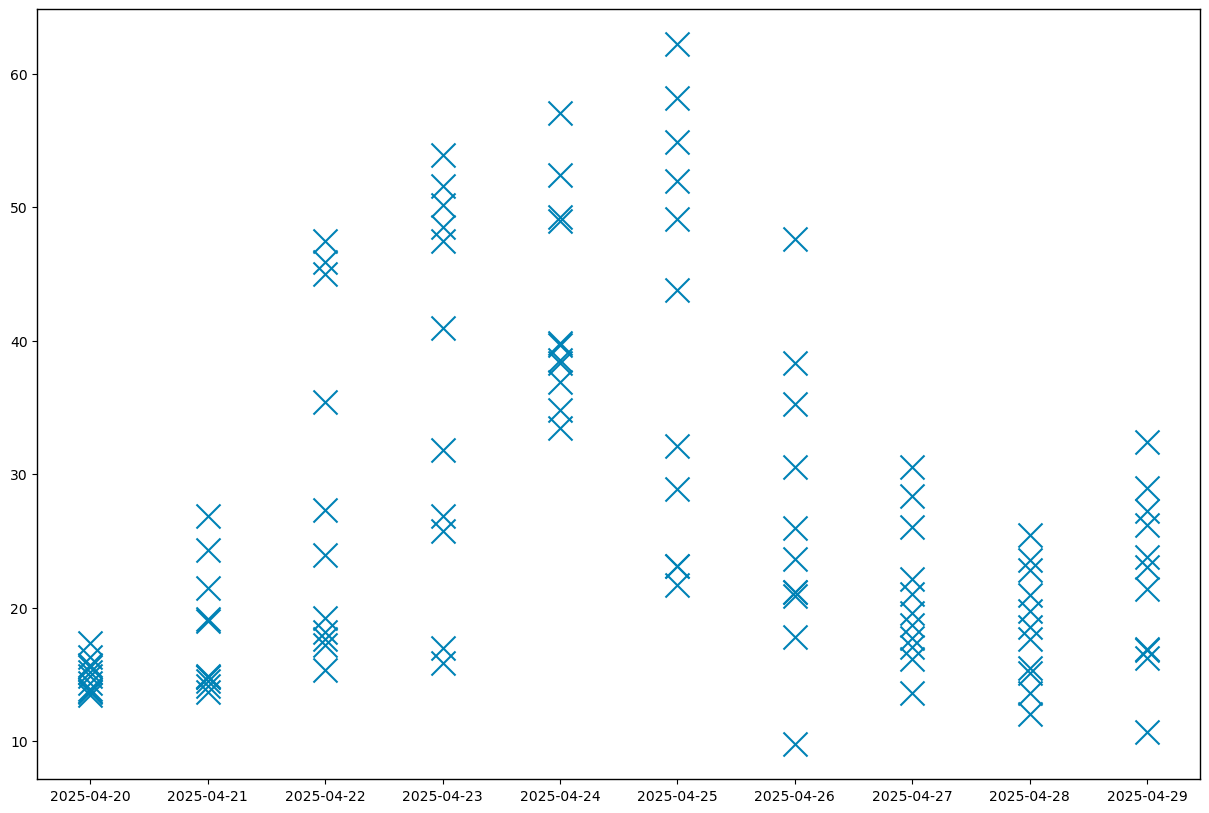

In [3]:
plt.figure(figsize=(15, 10))
for member in ensemble_members:
    plt.scatter(dates, member, s = 300, color=ecmwf_blue, marker = 'x', alpha= 1)
    random_alpha = random.uniform(0.3, 0.7)
    # plt.plot(dates[:2], member[:2], '-', color=ecmwf_blue, linewidth=1.5, alpha=random_alpha)

plt.grid(False)


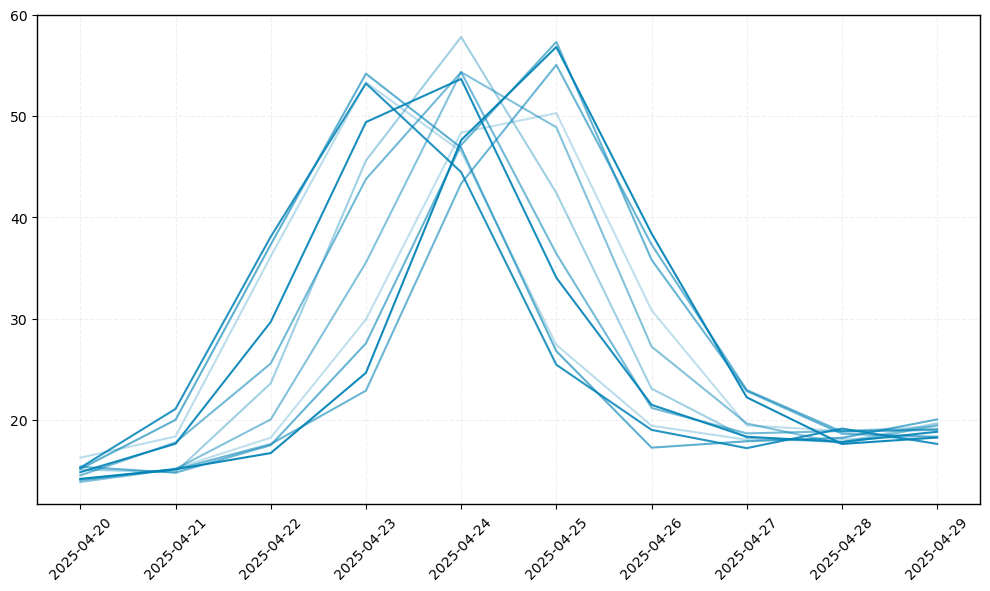

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
from matplotlib.patches import Patch
import matplotlib as mpl

# Set the seed for reproducibility
np.random.seed(42)

# Create date range for the 10-day hydrograph
start_date = datetime(2025, 4, 20)  # Start date
dates = [start_date + timedelta(days=i) for i in range(10)]

# Generate realistic streamflow data (in cubic meters per second)
# Base flow with some seasonal pattern
base_flow = 15 + 5 * np.sin(np.linspace(0, np.pi/4, 10))

# Create forecast data (center of the ensemble)
forecast_flow = base_flow.copy()
peak_position = 4
peak_height = 40
peak_width = 1.5
for i in range(10):
    forecast_flow[i] += peak_height * np.exp(-((i - peak_position) / peak_width) ** 2)

# Add some small random variations to the forecast
forecast_flow += np.random.normal(0, 0.5, 10)

# Create actual flow that will be within uncertainty bounds
# Using the same base pattern but with some variation
observed_flow = forecast_flow.copy()
# Shift the peak slightly and modify height within expected range
observed_shift = 0.2
observed_scale = 0.9  # Scale down slightly but still within bounds
for i in range(10):
    # Start with forecast and apply a transformation that keeps it mostly within bounds
    observed_flow[i] = forecast_flow[i] * (observed_scale + 0.15 * np.sin(i/2))

# Add slight random variations to make it look natural but still mostly within bounds
observed_flow += np.random.normal(0, 2, 10)

# Ensure no negative values
observed_flow = np.maximum(observed_flow, 0.5)
forecast_flow = np.maximum(forecast_flow, 0.5)

# Generate ensemble members with varying peak timing
n_ensemble = 11
ensemble_members = []
spread_factor = 2.5  # Spread factor for amplitude uncertainty

# Define the peak position and its uncertainty range
peak_position = 4
peak_timing_spread = 1  # Days of uncertainty in peak timing

for i in range(n_ensemble):
    # Create a unique member with shifted peak timing
    member = base_flow.copy()
    
    # Randomize peak timing for this ensemble member
    member_peak_position = peak_position + np.random.uniform(-peak_timing_spread, peak_timing_spread)
    peak_height_factor = np.random.uniform(0.9, 1.1)  # Allow some variation in peak height
    
    # Apply the peak with shifted timing for this member
    for j in range(10):
        member[j] += peak_height * peak_height_factor * np.exp(-((j - member_peak_position) / peak_width) ** 2)
    
    # Add increasing uncertainty with lead time
    uncertainty = np.linspace(0.9, 0.5, 10)
    member += np.random.normal(0, spread_factor/2, 10) * uncertainty  # Reduced noise since timing variation adds spread
    
    ensemble_members.append(np.maximum(member, 0.2))  # Ensure positive values

# Calculate ensemble statistics
ensemble_array = np.array(ensemble_members)
ensemble_mean = np.mean(ensemble_array, axis=0)
ensemble_median = np.median(ensemble_array, axis=0)
ensemble_min = np.min(ensemble_array, axis=0)
ensemble_max = np.max(ensemble_array, axis=0)
ensemble_25 = np.percentile(ensemble_array, 25, axis=0)
ensemble_75 = np.percentile(ensemble_array, 75, axis=0)
ensemble_10 = np.percentile(ensemble_array, 10, axis=0)
ensemble_90 = np.percentile(ensemble_array, 90, axis=0)

# Create a figure with ECMWF style
plt.figure(figsize=(10, 6))

# Set up the style to match ECMWF graphics
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# Define ECMWF-like colors
ecmwf_blue = '#0082B6'  # Main ECMWF blue
ecmwf_gray = '#666666'  # For grid and labels
ensemble_blue = '#A6CEE3'  # Lighter blue for ensemble spread

# Plot ensemble ranges (shaded areas for uncertainty)
# plt.fill_between(dates, ensemble_min, ensemble_max, color=ensemble_blue, alpha=0.2, label='Min-Max Range')
# plt.fill_between(dates, ensemble_10, ensemble_90, color=ensemble_blue, alpha=0.3, label='10-90th Percentile')
# plt.fill_between(dates, ensemble_25, ensemble_75, color=ensemble_blue, alpha=0.5, label='25-75th Percentile')

# Plot the forecast mean as a dashed line
# plt.plot(dates, ensemble_mean, '--', color=ecmwf_blue, linewidth=2, label='Ensemble Mean')

# Plot the forecast median as a solid line
# plt.plot(dates, ensemble_median, '-', color=ecmwf_blue, linewidth=2.5, label='Forecast')

# Plot the actual flow with a black line across all 10 days
# plt.plot(dates, observed_flow, '-', color='black', linewidth=2.5, label='Actual Flow')

# Add individual ensemble members with low opacity
for member in ensemble_members:
    random_alpha = random.uniform(0.25, 0.95)
    plt.plot(dates, member, '-', color=ecmwf_blue, linewidth=1.5, alpha=random_alpha)


# Customize the appearance
plt.grid(True, which='major', axis='both', linestyle='--', color='#CCCCCC')

plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for date labels

# Show the plot
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)

# Create date range for the 10-day hydrograph
start_date = datetime(2025, 4, 20)
dates = [start_date + timedelta(days=i) for i in range(10)]

# Set up the style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# Define colors
ecmwf_blue = '#0082B6'
ecmwf_gray = '#666666'

# Parameters
n_realizations = 5
n_ensemble_members = 1
base_flow = 15
peak_height = 40
peak_width = 1.5
spread_factor = 4.5

# Peak timings and magnitudes for different realizations
peak_positions = [4.0, 4.5, 3.5, 5.0, 4.2]
peak_scales = [1.0, 1.15, 0.85, 1.1, 0.95]

# ============================================================================
# Generate ensemble plots with different realizations
# ============================================================================

fig, axes = plt.subplots(n_realizations, 1, figsize=(10, 12))

for idx, ax in enumerate(axes):
    # Generate base flow pattern
    base = base_flow + 5 * np.sin(np.linspace(0, np.pi/4, 10))
    
    # Parameters for this realization
    peak_pos = peak_positions[idx]
    peak_scale = peak_scales[idx]
    peak_timing_spread = 1.0
    
    # Generate ensemble members for this realization
    ensemble_members = []
    
    for i in range(n_ensemble_members):
        member = base.copy()
        
        # Randomize peak timing for this ensemble member
        member_peak_pos = peak_pos + np.random.uniform(-peak_timing_spread, peak_timing_spread)
        peak_height_factor = peak_scale * np.random.uniform(0.8, 1.2)
        
        # Apply the peak with shifted timing
        for j in range(10):
            member[j] += peak_height * peak_height_factor * np.exp(-((j - member_peak_pos) / peak_width) ** 2)
        
        # Add increasing uncertainty with lead time
        uncertainty = np.linspace(0.7, 2.5, 10)
        member += np.random.normal(0, spread_factor/2, 10) * uncertainty
        
        ensemble_members.append(np.maximum(member, 0.2))
    
    # Plot individual ensemble members
    for member in ensemble_members:
        random_alpha = 1
        ax.plot(dates, member, '-', color= 'midnightblue', linewidth=1.5, alpha=random_alpha)
    
    # Customize each subplot
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.grid(True, which='major', axis='both', linestyle='--', color='#CCCCCC')
    
    # Remove tick labels but keep grid
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    
    ax.set_ylim(0, 80)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08, top=0.97)

# Add footer

plt.show()

NameError: name 'hysets_01652500' is not defined

In [ ]:

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_realizations = 5
n_timesteps = 100
time = np.arange(n_timesteps)

# ============================================================================
# PART 1: Random Noise Timeseries (separate plots)
# ============================================================================

fig1, axes1 = plt.subplots(n_realizations, 1, figsize=(10, 8))


for i, ax in enumerate(axes1):
    # Generate random noise (Gaussian white noise)
    noise = np.random.randn(n_timesteps)
    
    ax.plot(time, noise, linewidth=1.5, color='darkblue')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, n_timesteps-1)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
import importlib
import ML_functions
importlib.reload(ML_functions)


# Loading Datasets

In [ ]:
ERA5_zarr_path = '/perm/mokr/Caravans_MultiMet/ERA5_LAND/timeseries.zarr'
HRES_zarr_path = '/perm/mokr/Caravans_MultiMet/HRES_Jan/HRES/timeseries.zarr'

ERA5_Land = xr.open_zarr(store=ERA5_zarr_path, chunks= None)
HRES = xr.open_zarr(store=HRES_zarr_path, chunks= None)

# ERA5_Land = xr.open_zarr(ERA5_zarr_path, chunks={"basin": 1, "date": -1})
# HRES = xr.open_zarr(store=HRES_zarr_path, chunks={"basin": 1, "date": -1})

# ERA5_Land = xr.open_zarr(store=ERA5_zarr_path)
# HRES = xr.open_zarr(store=HRES_zarr_path)

# HRES = zarr.open('/perm/mokr/Caravans_MultiMet/HRES/timeseries.zarr')

In [ ]:

# Select the data
basin_data = ERA5_Land.sel(basin='hysets_05QA002', date=slice('2017-01-17', '2017-04-17'))

# Basic plotting of all variables
fig, axes = plt.subplots(nrows=len(basin_data.data_vars), figsize=(12, 3*len(basin_data.data_vars)))

# If there's only one variable, make axes iterable
if len(basin_data.data_vars) == 1:
    axes = [axes]

# Plot each variable
for i, var_name in enumerate(basin_data.data_vars):
    var_data = basin_data[var_name]
    
    # Plot time series
    var_data.plot(ax=axes[i])
    axes[i].set_title(f'{var_name} for basin hysets_01403060')
    axes[i].set_xlabel('Date')
    
    # Add appropriate y-label based on variable attributes if available
    if hasattr(var_data, 'units'):
        axes[i].set_ylabel(f'{var_name} ({var_data.units})')
    else:
        axes[i].set_ylabel(var_name)
        
    # Improve x-axis formatting
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# Select the time range
basin_data = HRES.sel(basin='hysets_01403060', date=slice('2017-04-14', '2017-04-24'))

# Get stats over leadtime
stats = {}
for var_name in basin_data.data_vars:
    var = basin_data[var_name]
    stats[var_name] = {
        'min': var.min(dim='lead_time'),
        'max': var.max(dim='lead_time'),
        'mean': var.median(dim='lead_time'),
        'var': var.var(dim='lead_time'),
    }

# Plotting
fig, axes = plt.subplots(nrows=len(basin_data.data_vars), figsize=(14, 4*len(basin_data.data_vars)))

# Make axes iterable
if len(basin_data.data_vars) == 1:
    axes = [axes]

for i, var_name in enumerate(basin_data.data_vars):
    ax = axes[i]
    
    ax.plot(stats[var_name]['mean']['date'], stats[var_name]['mean'], label='Mean', color='blue')
    ax.fill_between(
        stats[var_name]['mean']['date'],
        stats[var_name]['min'],
        stats[var_name]['max'],
        color='blue',
        alpha=0.2,
        label='Min-Max Range'
    )
    
    ax.set_title(f"{var_name} — Mean ± Range (over leadtimes)")
    ax.set_xlabel("Date")
    ax.set_ylabel(var_name)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

plt.show()

In [ ]:
basin_data.sel(date='2017-04-17')['hres_total_precipitation']

In [ ]:
Discharge = pd.read_csv('/home/mokr/Loss_Functions_Paper/Scaled/discharge_scaled.csv')

In [ ]:
Discharge[['date', 'hysets_05QA002']]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' is datetime
Discharge['date'] = pd.to_datetime(Discharge['date'])

# Filter by date range
mask = (Discharge['date'] >= '2017-04-17') & (Discharge['date'] <= '2017-04-30')
subset = Discharge.loc[mask]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(subset['date'], subset['hysets_05QA002'], marker='o')
plt.title('Discharge at Station hysets_05QA002 (17–30 April 2017)')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# First axis is basins, second axis is dates
# There are 7 more basins in HRES than in ERA5
ERA5_Land.info
HRES.info

In [ ]:
# date is just indexes, not timestamps or anything
dates = ERA5_Land['date'][:]
date_array = pd.to_datetime(dates)


In [ ]:
with open('/home/mokr/Loss_Functions_Paper/Caravans_2016_2019_Basins.txt', 'r') as file:
    Suitable_Basins = file.readlines()
    # This includes newline characters at the end of each line
    Suitable_Basins = [line.strip() for line in Suitable_Basins]  # removes newline characters

Data_Sources = set(path.split('/')[0] for path in Suitable_Basins)
Data_Sources_List = list(Data_Sources)

Basins = set(path.split('/')[1] for path in Suitable_Basins)
Basins_List = list(Basins)


basin_indices = np.where(np.isin(HRES['basin'].values, Basins_List))[0]
era5_basin_indices = np.where(np.isin(ERA5_Land['basin'].values, Basins_List))[0]


# Looking at Caravans

In [ ]:
# Selected_Basin = str(ERA5_Land['basin'][1700].basin.values) #2600 - 3100 all is camelsGB, could be good?
Selected_Basin = Basins_List[0]
basin_index = np.where(ERA5_Land['basin'][:] == Selected_Basin)[0]
location = Selected_Basin.split('_')[0]
print(location)

In [ ]:
start_date = "2016-01-01"
end_date = "2018-12-31"

start_date = pd.to_datetime("2016-01-01")
end_date = pd.to_datetime("2018-12-31")

valid_start_dates = pd.date_range(
    start=start_date, 
    end=pd.to_datetime(end_date) - pd.Timedelta(days=90), 
    freq='D'
)

# Something wrong with these
'hysets_11523200', 'hysets_07DB001' 


In [ ]:

location = 'hysets'
Selected_Basin = 'hysets_01652500'
# Selected_Basin = 'hysets_11523200'
# 742, 384

Basin_Discharge = pd.read_csv(f'/perm/mokr/Caravans/Caravan/timeseries/csv/{location}/{Selected_Basin}.csv') #This is missing places like denmark
Basin_Attributes = pd.read_csv(f'/perm/mokr/Caravans/Caravan/attributes/{location}/attributes_caravan_{location}.csv')

# prediction date and basin are tensor([132, 521]) ('hysets_03610000', 'hysets_01589317') 
# Basin_Discharge = pd.read_csv(f'/perm/mokr/Caravans/Caravan/timeseries/csv/camelsbr/camelsbr_56994500.csv')
# Basin_Attributes_Caravans = pd.read_csv(f'/perm/mokr/Caravans/Caravan/attributes/hysets/attributes_caravan_hysets.csv')
# Basin_Attributes_HydroAtlas = pd.read_csv(f'/perm/mokr/Caravans/Caravan/attributes/hysets/attributes_hydroatlas_hysets.csv')
Basin_Attributes_Other = pd.read_csv(f'/perm/mokr/Caravans/Caravan/attributes/hysets/attributes_other_hysets.csv')



Basin_Caravans = Basin_Discharge.set_index('date')
Basin_Caravans = ((Basin_Caravans - Basin_Caravans.mean())/Basin_Caravans.std())
Basin_Caravans.index = pd.to_datetime(Basin_Caravans.index)

columns_to_drop = [col for col in Basin_Caravans.columns if col.endswith(('min', 'max'))]

# Then remove these columns
Basin_Caravans = Basin_Caravans.drop(columns=columns_to_drop)

Basin_Discharge

# Assuming 'Basin_Caravans' is already set up with datetime index:
filtered_Basin_Caravans = Basin_Caravans.loc[start_date:end_date]
# print(filtered_Basin_Caravans.columns)
filtered_Basin_Caravans.dropna(axis=1, inplace = True) # Do this after subsetting by year, 'surface_net_solar_radiation_min' has nans in it for some reasons?

# Display the filtered data
# print(filtered_Basin_Caravans.columns)
filtered_Basin_Caravans['streamflow']

In [ ]:
Basin_Attributes[Basin_Attributes['gauge_id'] == 'hysets_01652500']

In [ ]:
Basin_Caravans[start_date:end_date].iloc[:, :-1]

In [ ]:
Specific_Basin_Attr = Basin_Attributes_Other[ Basin_Attributes_Other['gauge_id'] == 'hysets_01589317']
Specific_Basin_Pos = Specific_Basin_Attr[['gauge_lat', 'gauge_lon']]
Specific_Basin_Pos

# Getting scalers for ERA5 Land, Control Forecast, Streamflow, and Static Attributes data over training set

In [ ]:
# ERA5_Land HRES Basin_Caravans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import joblib

# Split into 80% training+val, 20% testing
train_val_basins, test_basins = train_test_split(Basins_List, test_size=0.2, random_state=42)
# Second split: Split the train_val set into 87.5% train, 12.5% val, so we get 70,10,20
train_basins, val_basins = train_test_split(train_val_basins, test_size=0.125, random_state=42)


In [ ]:
# 1. Normalize xarray variables using StandardScaler and only train_basins
def normalize_xarray_with_scaler(ds, train_basin_list):
    """
    Normalize an xarray dataset using StandardScaler fit on training basins only
    
    Parameters:
    -----------
    ds : xarray.Dataset
        The dataset to normalize
    train_basin_list : list
        List of basin IDs in the training set
    
    Returns:
    --------
    xarray.Dataset : Normalized dataset
    dict : Dictionary with fitted scalers for each variable
    """
    
    # Dictionary to store fitted scalers
    scalers = {}
    
    # Get data only from training basins
    ds_train = ds.sel(basin=train_basin_list)
    
    # Normalize each variable
    for var in ds.data_vars:
        # Create a scaler for this variable
        # print(var)
        scaler = StandardScaler()
        
        # Reshape the training data to 2D for fitting the scaler
        # (StandardScaler expects 2D data)
        train_data = ds_train[var].values.reshape(-1, 1)
        scaler.fit(train_data)
        
        # Store the fitted scaler
        scalers[var] = scaler
        
    return scalers


# Apply normalization to the xarrays
# ERA5_Land_scalers = normalize_xarray_with_scaler(ERA5_Land, train_basins)
# I'll use ERA5 o scale HRES, it's the same underlying variables and we want to preserve knowledge of model bias

In [ ]:
# Apply normalization to CSV files

# 2. Normalize CSV files for all basins
def normalize_csv_files(train_basin_list):
    """
    Normalize variables in CSV files using statistics from only the training basins
    
    Parameters:
    -----------
    train_basin_list : list
        List of basin IDs in the training set
    
    Returns:
    --------
    dict : Dictionary with normalization parameters for each variable
    """
    # Dictionary to store all training dataframes
    all_train_dfs = {}
    i = 0
    # First, collect all training dataframes
    for basin_idx in train_basin_list:
        location = basin_idx.split('_')[0]
        file_path = f'/perm/mokr/Caravans/Caravan/timeseries/csv/{location}/{basin_idx}.csv'
        df = pd.read_csv(file_path)
        all_train_dfs[basin_idx] = df['streamflow']
        del df
        i = i+1
        if i % 100 == 0:
            print(i)
    # Calculate normalization parameters from training data
    # Combine all training dataframes to calculate stats
    combined_train_df = pd.concat(all_train_dfs.values())

    # Dictionary to store fitted scalers
    scalers = {}
    
    scaler = StandardScaler()
    
    # Reshape the training data to 2D for fitting the scaler
    # (StandardScaler expects 2D data)
    train_data = combined_train_df.values.reshape(-1, 1)
    scaler.fit(train_data)
    
    # Store the fitted scaler
    scalers['streamflow'] = scaler

    return scalers
# Function to normalize a single CSV file using the parameters
def normalize_csv(basin_idx, params):
    location = basin_idx.split('_')[0]
    file_path = f'/perm/mokr/Caravans/Caravan/timeseries/csv/{location}/{basin_idx}.csv'
    df = pd.read_csv(file_path)
    
    # Create a copy for normalized data
    df_norm = df.copy()
    
    # Normalize numeric columns
    for col in params:
        if col in df.columns:
            mean = params[col]['mean']
            std = params[col]['std']
            df_norm[col] = (df[col] - mean) / std
    
    # Save normalized CSV
    norm_file_path = f'/perm/mokr/Caravans/Caravan/timeseries/csv_normalized/{location}/{basin_idx}.csv'
    # Make sure the directory exists
    import os
    os.makedirs(os.path.dirname(norm_file_path), exist_ok=True)
    df_norm.to_csv(norm_file_path, index=False)
    
    return df_norm
    
    # Process all basins (including test basins) using train statistics
    all_basin_idx = list(set([basin for basin in ERA5_Land.basin.values]))
    normalized_dfs = {}
    
    for basin_idx in all_basin_idx:
        normalized_dfs[basin_idx] = normalize_csv(basin_idx, norm_params)
    
    return norm_params, normalized_dfs


# csv_norm_params, normalized_csv_dfs = normalize_csv_files(train_basins)

discharge_caravan_scalers = normalize_csv_files(train_basins)



In [ ]:
discharge_caravan_scalers['streamflow'].var_

In [ ]:
# 3. Save normalization parameters for later use (e.g., for inference)
def save_scalers(scalers, output_path='scalers'):
    """Save all fitted scalers to files using joblib"""
    
    # Save ERA5 scalers
    joblib.dump(scalers, f'{output_path}.joblib')
    
# Example of how to load these scalers later
def load_scalers(output_path = 'scalers'):
    """Load saved scalers"""
    era5_scalers = joblib.load(f'{output_path}.joblib')
    return era5_scalers
# Static_df = pd.read_csv(f'/perm/mokr/Caravans/Caravan/attributes/{location}/attributes_caravan_{location}.csv')


# Save the scalers
# save_scalers(discharge_caravan_scalers, '/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Scalers/discharge_caravan_scalers')
ERA5_Land_scale_test = load_scalers('/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Scalers/ERA5_Land_Scalers')

In [ ]:
ERA5_Land_scale_test

# Plot of all Suitable Basins

In [ ]:
# Suitable Basins determined by another Jupyter notebook, need to download it
with open('/home/mokr/Loss_Functions_Paper/Caravans_2016_2019_Basins.txt', 'r') as file:
    Suitable_Basins = file.readlines()
    # This includes newline characters at the end of each line
    Suitable_Basins = [line.strip() for line in Suitable_Basins]  # removes newline characters

Data_Sources = set(path.split('/')[0] for path in Suitable_Basins)
Data_Sources_List = list(Data_Sources)

Basins = set(path.split('/')[1] for path in Suitable_Basins)
Basins_List = list(Basins)


Catchment_Attributes = pd.DataFrame()
for Suitable_Basin in Suitable_Basins:
    location = Suitable_Basin.split('/')[0]
    Basin = Suitable_Basin.split('/')[1]
    Basin_Attributes_Other = pd.read_csv(f'/perm/mokr/Caravans/Caravan/attributes/{location}/attributes_other_{location}.csv')
    Location_Attr = Basin_Attributes_Other[ Basin_Attributes_Other['gauge_id'] == Basin]
    Catchment_Attributes = pd.concat([Catchment_Attributes, Location_Attr], ignore_index=True)
    
    

In [ ]:
Catchment_Attributes = pd.DataFrame()
for Suitable_Basin in val_basins:
    location = Suitable_Basin.split('_')[0]
    Basin = Suitable_Basin
    Basin_Attributes_Other = pd.read_csv(f'/perm/mokr/Caravans/Caravan/attributes/{location}/attributes_other_{location}.csv')
    Location_Attr = Basin_Attributes_Other[ Basin_Attributes_Other['gauge_id'] == Basin]
    Catchment_Attributes = pd.concat([Catchment_Attributes, Location_Attr], ignore_index=True)
    

In [ ]:
import pickle
with open("/home/mokr/Loss_Functions_Paper/Catchment_Averaging/ML_basin_splits.pkl", "rb") as f:
    basin_splits = pickle.load(f)

train_basins, val_basins, test_basins = basin_splits['train'], basin_splits['val'], basin_splits['test']

In [ ]:
Catchment_subset[Catchment_subset['country'] == 'United States of America']

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Catchment_subset = Catchment_Attributes[Catchment_Attributes['area'] > 5000]

gauge_lats = Catchment_subset['gauge_lat']
gauge_lons = Catchment_subset['gauge_lon']

gdf = gpd.GeoDataFrame(
    Catchment_subset,
    geometry=gpd.points_from_xy(gauge_lons, gauge_lats),
    crs="EPSG:4326"  # WGS 84 coordinate system
)

# Plot the world map
fig, ax = plt.subplots(figsize=(12, 8))
# world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Overlay gauge locations
gdf.plot(ax=ax, color='red', markersize=10, label='Gauge Locations')

# Customize plot
plt.title("Gauge Locations on World Map", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
start = '2016-01-01'
end = '2018-12-31'
# Filter Basin_Discharge for dates in this range
filtered_data = Basin_Discharge[
    (Basin_Discharge['date'] >= start) & 
    (Basin_Discharge['date'] <= end)
]

# No missing data in this range
# filtered_data.isna().sum()


# Downloading ML packages, defining models

In [5]:
import random
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from collections import defaultdict
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import joblib

from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

import ML_functions
from ML_functions import KGELoss
from ML_functions import HydroDataset

# Making different dataloaders

In [6]:
# Sampled_basins = xr.open_dataset('/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Sampled_Catchments/ERA5_Sampled_Catchments.zarr')

In [6]:
# camels_br_valid_files 
start_date = "2016-01-01"
end_date = "2018-12-24"
valid_start_dates = pd.Series(pd.date_range(
    start=start_date, 
    end=pd.to_datetime(end_date) - pd.Timedelta(days=90), 
    freq='D'
))

NameError: name 'pd' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# # Split into 80% training+val, 20% testing
# train_val_basins, test_basins = train_test_split(Basins_List, test_size=0.2, random_state=42)
# # Second split: Split the train_val set into 87.5% train, 12.5% val, so we get 70,10,20
# train_basins, val_basins = train_test_split(train_val_basins, test_size=0.125, random_state=42)

# Instantiate the dataset
# dataset = ML_functions.LSTMDataGenerator(
#     valid_start_dates=valid_start_dates,
#     ERA5_Land=ERA5_Land,
#     Caravans=Basin_Caravans,
#     Discharge=Basin_Discharge_Y,
#     basin_index=basin_index,
#     variables=variables
# )

# start_basin = 0
# num_basins = 3000

# Create a DataLoader
batch_size = 4
history_sequence_length = 90
forecast_sequence_length = 10

# Change Caravans to one of everything, Discharge, Basin_indices
# Basins_List insetad of indices
# Static_scalers = joblib.load(f'/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Scalers/static_caravan_scalers.joblib')
# discharge_scalers = joblib.load(f'/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Scalers/discharge_caravan_scalers.joblib')
# ERA5_Land_scalers = joblib.load(f'/home/mokr/Loss_Functions_Paper/Scalers/ERA5_Land_Scalers.joblib')

# scalers = ERA5_Land_scalers

# Static_df = pd.read_csv(f'/home/mokr/Loss_Functions_Paper/Scaled/static_caravan_scalers.csv')
# Discharge = pd.read_csv('/home/mokr/Loss_Functions_Paper/Scaled/discharge_scaled.csv')
# Discharge = Discharge.set_index('date')
# Discharge.index = pd.to_datetime(Discharge.index)

# Change Caravans to one of everything, Discharge, Basin_indices

# Basins_List insetad of indices

loaded_traning_data0 = torch.load("/perm/mokr/10Day_Loss_Function_Training_Dataset0_test.pt")
Training_Dataset0 = HydroDataset(loaded_traning_data0)

# loaded_traning_data1 = torch.load("/perm/mokr/Loss_Function_Training_Dataset1.pt")
# Training_Dataset1 = HydroDataset(loaded_traning_data1)

# loaded_traning_data2 = torch.load("/perm/mokr/Loss_Function_Training_Dataset2.pt")
# Training_Dataset2 = HydroDataset(loaded_traning_data2)

# combined_data = []
# datasets = [Training_Dataset0, Training_Dataset1]

# # Append data from each dataset to the combined list
# for dataset in datasets:
#     combined_data.extend(dataset.data)

# Full_Training_Dataset = HydroDataset(combined_data)


Training_Dataloader = DataLoader(Training_Dataset0, batch_size=batch_size, shuffle=True, pin_memory=True)



# loaded_validation_data = torch.load("/perm/mokr/10Day_Loss_Function_Validation_Dataset.pt")
# Validation_Dataset = HydroDataset(loaded_validation_data)
Validation_Dataloader = DataLoader(Training_Dataset0, batch_size= 1, shuffle=False, pin_memory=True)

In [3]:

loaded_validation_data = torch.load("/perm/mokr/10Day_Loss_Function_Validation_Dataset_Binary_P0.pt")
Validation_Dataset = HydroDataset(loaded_validation_data)
Validation_Dataloader = DataLoader(Validation_Dataset, batch_size= 1, shuffle=False, pin_memory=True)

/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.24889779/ipykernel_1857825/1644605864.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_validation_data 

In [13]:
target_ids = ['hysets_06327500', 'hysets_12324400']

# Create a dictionary to hold lists for each target ID
filtered_data = {station_id: [] for station_id in target_ids}

# Loop through your data and distribute accordingly
for entry in loaded_validation_data:
    key = entry[4]
    if key in filtered_data:
        filtered_data[key].append(entry)

# Unpack to individual variables (optional)
hysets_06327500_data = filtered_data['hysets_06327500']
hysets_12324400_data = filtered_data['hysets_12324400']

Hysets_06327500_Dataloader = DataLoader(hysets_06327500_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_12324400_Dataloader = DataLoader(hysets_12324400_data, batch_size= 1, shuffle=False, pin_memory=True)


In [ ]:
# for Hind_X_batch, Fore_X_batch, Y_batch in HF_dataloader:
#     print('Hindcast Batch Shape', Hind_X_batch.shape)  # e.g., (batch_size, sequence_length, num_features)
#     print('Forecast Batch Shape', Fore_X_batch.shape)  # e.g., (batch_size, sequence_length, num_features)
#     print('Target Batch Shape', Y_batch.shape)  # e.g., (batch_size,)
#     break



# Example of iterating through batches
# for X_batch, Y_batch in dataloader:
#     print(X_batch.shape)  # e.g., (batch_size, sequence_length, num_features)
#     print(Y_batch.shape)  # e.g., (batch_size,)
#     break


for Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx in Training_Dataloader:
    print(Hist_X_Chunk_Torch.shape)  # e.g., (batch_size, sequence_length, num_features)
    print(Fore_X_Chunk_Torch.shape)  # e.g., (batch_size,)
    print(Y_value.shape)  
    # print(date_idx)
    print(basin_idx)
    break

# Loss Functions


In [ ]:
hindcast_hidden_size = 32
forecast_hidden_size = 16
handoff_hidden_size = 24

G_Model_CMAL1 = ML_Models.Google_Model_Block(25, 15, 8, 4, hindcast_hidden_size, forecast_hidden_size,  handoff_hidden_size, 1, 'cpu')
G_Model_CMAL3 = ML_Models.Google_Model_Block(25, 15, 8, 12, hindcast_hidden_size, forecast_hidden_size,  handoff_hidden_size, 1, 'cpu')

optimizer = optim.Adam(G_Model_CMAL3.parameters(), lr= 1e-3)

criterion = CMALLoss()
G_Model_CMAL3.train(True)


In [ ]:
# Loss is geting negative, why??

i = 0
size = 2000

optimizer = optim.Adam(G_Model_CMAL3.parameters(), lr= 1e-2)
criterion = CMALLoss()
G_Model_CMAL3.train(True)

average_loss = 0

epochs = 30
for epoch in range(epochs):
    for Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_values, end_prediction_date, basin_idx in Training_Dataloader:
        ground_truth = {}
        ground_truth['y'] = Y_values
        
        i = i+1
        
        predictions = G_Model_CMAL3(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1].squeeze()
        predictions = trancsform_CMAL_parameters_multi(predictions)
        loss = 0
        for day in range(len(predictions)):
      
            prediction = {}
            prediction = {
                'mu': predictions[:, day, ::4],   # mu is at indices 0 mod 4
                'b': predictions[:, day, 1::4],   # b is at indices 1 mod 4 (ensure positive)
                'tau': predictions[:, day, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
                'pi': predictions[:, day, 3::4],  # pi is at indices 3 mod 4
            }
            
            # ground_truth = {}
            ground_truth = {'y': Y_values[:, day]}
            
            loss += criterion(prediction, ground_truth)
        if torch.isnan(loss):
            print('prediction date and basin are', end_prediction_date, basin_idx, 'Prediction is', prediction)
            break

        
        for name, param in G_Model_CMAL3.named_parameters():
            if param.requires_grad and torch.isnan(param).any():
                break
      
        average_loss += loss
        
        if i % size == 0:
            i = 0
            print('Average loss is', average_loss/size)
            average_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            average_loss = 0
    print('Average loss is', average_loss/size)
    average_loss = 0


In [ ]:
samples = draw_from_CMAL_distribution(prediction)
np.quantile(samples[0], [0.1,0.5,0.9, 0.999])

# CRPS Loss

In [ ]:
import torch
import torch.nn as nn

class CRPSLoss(nn.Module):
    """
    Continuous Ranked Probability Score (CRPS) implemented as a PyTorch loss function.
    
    This loss function evaluates the quality of probabilistic forecasts by comparing
    the forecasted distribution with the observed values.
    
    Lower CRPS values indicate better forecasts.
    """
    
    def __init__(self, clip_value=-0.26787253, smooth_epsilon=0.01):
        """
        Initialize the CRPS loss function.
        
        Args:
            clip_value (float): Value to clip forecasts at. Defaults to -0.26787253.
            smooth_epsilon (float): Parameter for smoothing the heaviside function.
        """
        super(CRPSLoss, self).__init__()
        self.clip_value = clip_value
        self.smooth_epsilon = smooth_epsilon
        
    def smooth_heaviside(self, x, epsilon=0.01):
        """
        Smooth approximation of the heaviside function that maintains gradients.
        
        Args:
            x: Input tensor
            epsilon: Smoothing parameter (smaller = sharper transition)
            
        Returns:
            Smoothed approximation of the heaviside function
        """
        return torch.sigmoid(x / epsilon)        
    def forward(self, forecasts, observation):
        """
        Calculate the Continuous Ranked Probability Score (CRPS).
        
        Args:
            forecasts: Tensor of ensemble forecasts with shape (n_members, batch_size, num_steps)
            observation: Tensor of true observations with shape (batch_size, num_steps)
            
        Returns:
            Tensor of CRPS scores with shape (batch_size, num_steps)
        """
        # Clip forecasts if needed
        forecasts = torch.clamp(forecasts, min=self.clip_value)
        
        # Get dimensions
        n_members, batch_size, num_steps = forecasts.shape
        
        # Reshape forecasts to (batch_size * num_steps, n_members)
        forecasts_reshaped = forecasts.permute(1, 2, 0).reshape(batch_size * num_steps, n_members)
        
        # Sort the forecasts along the ensemble dimension
        sorted_forecasts, _ = torch.sort(forecasts_reshaped, dim=1)
        
        # Reshape observations to match forecasts
        observations_flat = observation.reshape(batch_size * num_steps, 1)
        observations_expanded = observations_flat.expand(-1, n_members)
        
        # Calculate heaviside function (indicator of whether forecast >= observation)
        heaviside  = self.smooth_heaviside(sorted_forecasts - observations_expanded, self.smooth_epsilon)
        # Create ranks and normalize
        ranks = torch.arange(1, n_members + 1, device=forecasts.device, dtype=torch.float) / n_members
        
        # Calculate CRPS
        crps_flat = torch.mean((heaviside - ranks)**2, dim=1)
        
        # Reshape back to (batch_size, num_steps)
        crps_scores = crps_flat.reshape(batch_size, num_steps)
        
        return crps_scores

# Running and Training a model

In [ ]:
from ML_functions import run_ensemble_predictions
from ML_Models CMALLoss, KGELoss

In [ ]:
# hindcast_input_size, forecast_input_size, hindcast_output_size, forecast_output_size, hindcast_hidden_size, forecast_hidden_size, handoff_hidden_size, num_layers, device, dropout = 0.0, bidirectional = False, eval_dropout = True
hindcast_hidden_size = 32
forecast_hidden_size = 32 
handoff_hidden_size = 16
G_Model = ML_Models.Google_Model_Block(26, 16, 8, 1, hindcast_hidden_size, forecast_hidden_size, handoff_hidden_size, 1, device = 'cpu', dropout = 0.2, bidirectional = False, eval_dropout = False )
optimizer = optim.Adam(G_Model.parameters(), lr= 1e-4)

# criterion = nn.MSELoss()
criterion = CRPSLoss()
# criterion = NSELoss()
# criterion = CMALLoss()
G_Model.train(True)

In [ ]:
def check_nan_in_model(model):
    for name, param in model.named_parameters():
        if param.requires_grad and torch.isnan(param).any():
            print(f"NaNs found in parameter: {name}")
            return True
    print("No NaNs found in model parameters.")
    return False

# Example usage:
check_nan_in_model(G_Model)

In [ ]:
def run_ensemble_predictions(Model, Hist_X, Fore_X, num_members=4, noise_scale=1.0):
    """
    Run model predictions with an additional row of random noise each time.
    
    Args:
        Model: The model to generate predictions
        Hist_X: Historical data tensor [batch_size, seq_len, features]
        Fore_X: Forecast data tensor [batch_size, seq_len, features]
        num_members: Number of ensemble members to generate
        noise_scale: Scale of random noise to add
        
    Returns:
        Tensor of ensemble predictions [num_members, batch_size, num_steps]
    """
    batch_size = Hist_X.shape[0]
    hist_seq_len = Hist_X.shape[1]
    hist_features = Hist_X.shape[2]
    fore_seq_len = Fore_X.shape[1]
    fore_features = Fore_X.shape[2]
    device = Hist_X.device
    
    # List to store all predictions
    all_predictions = []


    for member_idx in range(num_members):
        # Create noise rows for both historical and forecast data
        hist_noise = noise_scale * torch.randn(batch_size, hist_seq_len, 1, device=device)
        fore_noise = noise_scale * torch.randn(batch_size, fore_seq_len, 1, device=device)
        
        # Concatenate noise as an additional feature
        hist_with_noise = torch.cat([Hist_X, hist_noise], dim=2)
        fore_with_noise = torch.cat([Fore_X, fore_noise], dim=2)
        
        # Run the model with the augmented input
        prediction = Model(hist_with_noise, 
                            fore_with_noise)[1]
        
        # Add this prediction to our collection
        all_predictions.append(prediction)
    
    # Stack all predictions to create a tensor with shape [num_members, batch_size, num_steps]
    ensemble_predictions = torch.stack(all_predictions, dim=0)
    
    return ensemble_predictions

In [ ]:
i = 0
size = 300

optimizer = optim.Adam(G_Model.parameters(), lr= 1e-4)

criterion = CRPSLoss()
G_Model.train(True)

average_loss = 0

epochs = 3
for epoch in range(epochs):
    for Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, end_prediction_date, basin_idx in Training_Dataloader:

    
        i = i+1
        
        # print(basin_idx, date_idx)
        # Use X_batch and Y_batch for training

        Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:, 0:15]
        # prediction = G_Model(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]
        # prediction = LSTM_Example(Hist_X_Chunk_Torch.to(torch.float32))

        ensemble_predictions = run_ensemble_predictions(G_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, num_members=6, noise_scale=1.0)
        
        # Now ensemble_predictions has shape [num_members, batch_size, num_steps]
        
        # Calculate CRPS loss using the ensemble predictions
        crps_loss = criterion(ensemble_predictions.squeeze(), Y_value)
        loss = crps_loss.mean()

    
        if torch.isnan(loss):
            print('prediction date and basin are', end_prediction_date, basin_idx, 'Prediction is', prediction)
            break
            
        for name, param in G_Model.named_parameters():
            if param.requires_grad and torch.isnan(param).any():
                break
      
        average_loss += loss
        
        if i % size == 0:
            i = 0
            print('Average loss is', average_loss/size)
            average_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            average_loss = 0
    print('Average loss is', average_loss/size)
    average_loss = 0


In [ ]:
gamma = 0.95
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

train_seeded_model(G_Model, optimizer, Training_Dataloader, epochs=3, batch_accumulation_size=300, 
              num_ensemble_members=4, noise_scale=1.0,
              criterion=None, scheduler = scheduler, train_mode = True)

In [ ]:
def train_seeded_model(model, optimizer, Training_Dataloader, epochs=3, batch_accumulation_size=300, 
              num_ensemble_members=4, noise_scale=1.0,
              criterion=None, scheduler = None, train_mode = True):
    """
    Train a model using ensemble predictions and batch accumulation.
    
    Parameters:
    -----------
    G_Model : torch.nn.Module: The model to train
    Training_Dataloader : torch.utils.data.DataLoader: DataLoader containing training data
    epochs : int: Number of epochs to train for
    batch_accumulation_size : int: Number of batches to accumulate before performing gradient update
    learning_rate : float: Learning rate for optimizer
    num_ensemble_members : int: Number of ensemble members to generate during training
    noise_scale : float: Scale of noise to use in ensemble predictions
    criterion : torch.nn.Module: Loss function to use (defaults to CRPSLoss if None)

    Returns:
    --------
    list
        Training loss history
    """

    # Use provided criterion or default to CRPSLoss
    if criterion is None:
        criterion = CRPSLoss_Ensemble()

    if train_mode:
        model.train(True)
    
    average_loss = 0
    i = 0
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0
        
        for Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, end_prediction_date, basin_idx in Training_Dataloader:
            i = i + 1
            batch_count += 1
            
            # Trim forecast features
            Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:, 0:15]
            
            # Generate ensemble predictions
            ensemble_predictions = run_ensemble_predictions(model, 
                Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32),
                num_members=num_ensemble_members, noise_scale=noise_scale)
            
            # Calculate loss using the ensemble predictions
            batch_loss = criterion(ensemble_predictions.squeeze(), Y_value)
            loss = batch_loss.mean()

            # Accumulate loss (without backpropagation yet)
            average_loss += loss
            epoch_loss += loss.item()

            # Backpropagate the accumulated loss
            loss.backward()
            # Update parameters and reset gradients
            optimizer.step()
            optimizer.zero_grad()
            
            if scheduler is not None:
                scheduler.step()

            if i % batch_accumulation_size == 0:
                i = 0
                avg_batch_loss = average_loss / batch_accumulation_size
                print(f'Batch {batch_count}, Average loss: {avg_batch_loss.item():.6f}')
                loss_history.append(avg_batch_loss.item())
                average_loss = 0
        
        
        print(f'Epoch {epoch+1} complete, average loss: {epoch_loss/batch_count:.6f}')
    
    return loss_history

In [ ]:
crps_loss.mean()

In [ ]:
ensemble_predictions.shape

In [ ]:
predictions = []
Seeded_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Seeded/hyperparameter_test/Seeded_lr_0.001_bi_False_h_128_128_64_0506_30Epochs.pth', map_location=torch.device('cpu')) # Best Seeded Model so far

for Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, end_prediction_date, basin_idx in Validation_Dataloader:
    for i in range (11):
    
        # print(basin_idx, date_idx)
        # Use X_batch and Y_batch for training
    
        Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:, 0:15]
        prediction = Seeded_Model(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]
        predictions.append(prediction.detach().numpy())
        break


In [ ]:
num_days  = 10
plt.figure(figsize=(12, 6))

# Calculate mean and confidence intervals
mean_forecast = np.mean(predictions, axis=0).squeeze()
lower_95 = np.percentile(predictions, 2.5, axis=0).squeeze()
upper_95 = np.percentile(predictions, 97.5, axis=0).squeeze()
lower_50 = np.percentile(predictions, 25, axis=0).squeeze()
upper_50 = np.percentile(predictions, 75, axis=0).squeeze()

# Plot mean line
plt.plot(range(num_days), mean_forecast, '-', color= 'blue', linewidth=2, label= 'ensemble')
plt.plot(range(num_days), Y_value.squeeze(), '-', color= 'black', linewidth=2, label= 'observations')

for i in range(len(predictions)):
    plt.plot(range(num_days), predictions[i].squeeze(), '-', color='gray', alpha=0.15, linewidth=0.8)
    
# Plot 95% confidence interval (lighter shade)
plt.fill_between(range(num_days),  lower_95, upper_95, color= 'blue', alpha=0.2)

# Plot 50% confidence interval (darker shade)
plt.fill_between(range(num_days),  lower_50, upper_50, color= 'blue', alpha=0.4)

# Formatting
plt.xlabel('Leadtime', fontsize=12)
plt.ylabel('Forecast Value', fontsize=12)
plt.title('10-Day Forecasts with Confidence Intervals', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')

# Format x-axis dates
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# G_Model = torch.load('/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Models/G_Model_Deterministic.pth')

save_path = '/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Models/G_Model_Deterministic.pth'
torch.save(G_Model, save_path)


In [ ]:
def plot_timeseries_grid(data):
    """
    Plot 40 time series in a grid layout
    """
    if data.dim() == 3:
        data = data.squeeze(0)
    
    data_np = data.numpy()
    
    # Calculate grid dimensions
    rows = int(np.ceil(np.sqrt(data_np.shape[1])))
    cols = int(np.ceil(data_np.shape[1] / rows))
    
    plt.figure(figsize=(20, 15))
    
    for i in range(data_np.shape[1]):
        plt.subplot(rows, cols, i+1)
        plt.plot(data_np[:, i])
        plt.title(f'Series {i+1}')
    
    plt.tight_layout()
    plt.show()

plot_timeseries_grid(Hist_X_Chunk_Torch)

In [ ]:
Hist_X_Chunk_Torch
Fore_X_Chunk_Torch
# Y_value

nan_mask = torch.isnan(Fore_X_Chunk_Torch)

if nan_mask.any():
    print("NaNs found")
else:
    print("No NaNs found")

# Evaluating Models

In [9]:
import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

from ML_Plots import  CMAL_quantile, transform_CMAL_parameters, draw_from_CMAL_distribution, draw_from_CMAL_distribution_np, load_and_unnormalize, get_ensemble_members_vectorized, plot_ensemble_predictions

from ML_Losses import compute_log_likelihood, compute_CDF, crps_loss, compute_crps, calculate_overall_crps, get_member_summaries_torch

from ML_functions import transform_CMAL_parameters_multi, run_ensemble_predictions

In [10]:
# j = 2 [3*365*j : 3*365*(j+1)]
Validation_Dataset = Training_Dataset0 
Validation_Dataloader = DataLoader(Validation_Dataset, batch_size= 1, shuffle=True, pin_memory=True)

NameError: name 'Training_Dataset0' is not defined

In [ ]:
def multi_plot_predictions_vs_observations(model, dataloader, num_samples=365):
    model.eval()  # Set model to evaluation mode
    predictions = []
    observations = []
    
    with torch.no_grad():
        for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            # Get prediction
            pred = model(x)
            
            # Store prediction and observation
            predictions.append(pred.squeeze().cpu().numpy())
            observations.append(y.squeeze().cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    observations = np.array(observations)
    
    # Create time index
    time_index = np.arange(len(predictions))
    
    # Create the plot
    plt.figure(figsize=(15, 6))
    plt.plot(time_index, observations, label='Observations', color='blue', alpha=0.7)
    plt.plot(time_index, predictions, label='Predictions', color='red', alpha=0.7)
    
    # Add bands for prediction uncertainty if available
    # plt.fill_between(time_index, predictions - std, predictions + std, 
    #                 color='red', alpha=0.2, label='Prediction Uncertainty')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('River Discharge Predictions vs Observations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calculate metrics
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((observations - predictions) ** 2) / 
               np.sum((observations - np.mean(observations)) ** 2))
    
    # Kling-Gupta Efficiency (KGE)
    kge = calculate_kge(observations, predictions)
    
    # R-squared (R²)
    r2 = np.corrcoef(observations, predictions)[0, 1]**2
    
    print(f'NSE: {nse:.4f}')
    print(f'KGE: {kge:.4f}')
    print(f'R²: {r2:.4f}')
    plt.show()
    
    return predictions, observations

In [23]:
import numpy as np

In [24]:

G_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/hyperparameter_test/model_lr_0.001_bi_False_h_64_64_32_0428_30Epochs.pth', map_location=torch.device('cpu'))
Seeded_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Seeded/hyperparameter_test/Seeded_lr_0.001_bi_False_h_128_128_64_0514_8_5Epochs.pth', map_location=torch.device('cpu')) # Best Seeded Model so far

Seeded_Model.eval()
G_Model.eval()  # Set model to evaluation 

G_Model.to('cpu')
predictions_list = []
observations_list = []
dates = [] #start of historical time series
num_forecasts  = 720
with torch.no_grad():
    for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Hysets_12324400_Dataloader):
        if i >= num_forecasts:
            break
            
        # Get prediction
        Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:, 0:15]
        predictions = run_ensemble_predictions(Seeded_Model, Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32), num_members=11, noise_scale=1.0)
        # predictions = G_Model(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]

        predictions = predictions.squeeze()
        predictions = predictions.unsqueeze(0)
        predictions = transform_CMAL_parameters_multi(predictions)

        predictions = predictions.squeeze()
        observations = Y_value.squeeze()
        predictions, observations = load_and_unnormalize(predictions, observations)

        # Store prediction and observation
        predictions_list.append(predictions.squeeze())
        observations_list.append(observations.squeeze())
        dates.append(date_idx)

time_index = np.arange(len(predictions_list))

/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.19753732/ipykernel_1359153/2533590987.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_Model = torch.load('/

In [20]:
predictions.shape

torch.Size([11, 1, 10, 1])

In [25]:
import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

from ML_Plots import kl_divergence, CMAL_quantile, transform_CMAL_parameters, draw_from_CMAL_distribution, draw_from_CMAL_distribution_np, load_and_unnormalize, get_ensemble_members_vectorized, plot_ensemble_predictions, generate_greedy_trajectories, plot_dispersion_histograms, plot_uniform_qq, load_and_unnormalize

from ML_Losses import compute_log_likelihood, compute_CDF, crps_loss, compute_crps, calculate_overall_crps, get_member_summaries_torch

In [26]:
def generate_forecast_data(model, Validation_Dataloader, num_forecasts=180, num_members=11, noise_scale=1.0, device='cpu'):
    """
    Generate ensemble forecasts and corresponding observations from a validation dataloader.
    
    Parameters:
    -----------
    G_Model : torch.nn.Module: The model to use for predictions
    Validation_Dataloader : torch.utils.data.DataLoader: DataLoader containing validation data
    num_forecasts : int, default=180: Number of forecasts to generate
    num_members : int, default=11: Number of ensemble members to generate
    noise_scale : float, default=1.0: Scale of noise to use in ensemble predictions
    device : str, default='cpu': Device to run the model on
        
    Returns:
    --------
    dict
        A dictionary containing:
        - 'predictions_list': List of ensemble predictions
        - 'observations_list': List of corresponding observations
        - 'dates': List of date indices
        - 'time_index': Array of time indices
    """

    model.eval()  # Set model to evaluation mode
    model.to(device)
    
    predictions_list = []
    observations_list = []
    dates = []  # start of historical time series
    
    with torch.no_grad():
        for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):
            if i >= num_forecasts:
                break
                
            # Get prediction
            Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:, 0:15]
            predictions = run_ensemble_predictions(model, Hist_X_Chunk_Torch.to(torch.float32).to(device), Fore_X_Chunk_Torch.to(torch.float32).to(device), num_members=num_members, noise_scale=noise_scale)
            predictions[predictions < -0.26787253] = -0.2678724
            # predictions = G_Model(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]
            # predictions = transform_CMAL_parameters_multi(predictions)
            
            predictions = predictions.squeeze()
            observations = Y_value.squeeze()
            predictions, observations = load_and_unnormalize(predictions, observations)

            # Store prediction and observation
            predictions_list.append(predictions.squeeze())
            observations_list.append(observations.squeeze())
            dates.append(date_idx)
            
    time_index = np.arange(len(predictions_list))
    
    return {
        'predictions_list': predictions_list,
        'observations_list': observations_list,
        'dates': dates,
        'time_index': time_index
    }    

    


In [ ]:
for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):
        
    # Get prediction
    Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:, 0:15]
    predictions = run_ensemble_predictions(Seeded_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, num_members=11, noise_scale=1)
    predictions[predictions < -0.26787253] = -0.2678724
    # predictions = G_Model(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]
    # predictions = transform_CMAL_parameters_multi(predictions)
    
    predictions = predictions.squeeze()
    observations = Y_value.squeeze()
    predictions, observations = load_and_unnormalize(predictions.detach(), observations.detach())

    if Y_value.max() > 0.5:
            
        # X-axis values (days)
        days = np.arange(1, 11)

        # Create the plot
        plt.figure(figsize=(10, 6))
        # Plot each ensemble member
        for i in range(predictions.shape[0]):
            random_alpha = random.uniform(0.2, 0.7)
            plt.plot(days, predictions[i], 'b-', alpha=random_alpha, label=f'Ensemble Member' if i == 0 else None)
        
        # Plot the observations
        plt.plot(days, observations, 'r-', linewidth=2, label='Observations')
        
        # Add labels and legend
        plt.xlabel('Days')
        plt.ylabel('Value')
        plt.title('Ensemble Forecasts vs Observations')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Show the plot
        plt.tight_layout()
        plt.show()

In [53]:
Validation_Dataloader = DataLoader(Training_Dataset0, batch_size= 4, shuffle=False, pin_memory=True)

In [137]:
predictions_list = []
discharges = []
CRPS_Per_leadtime = []

for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):
        
    # Get prediction
    Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:, 0:15]
    predictions = run_ensemble_predictions(Seeded_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, num_members=11, noise_scale=1)
    predictions[predictions < -0.26787253] = -0.2678724

    predictions = predictions.squeeze()
    observations = Y_value
    
    predictions, observations = load_and_unnormalize(predictions.detach(), observations.detach())
    predictions, observations = torch.from_numpy(predictions).float(), torch.from_numpy(observations).float()
    predictions_summary = get_member_summaries_torch(predictions)
    discharge_summary = get_member_summaries_torch(observations.unsqueeze(0))
    crps = compute_crps(predictions, observations)

    predictions_list.append(predictions_summary)
    discharges.append(discharge_summary) 
    CRPS_Per_leadtime.append(crps)

    if i%50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650


KeyboardInterrupt: 

In [138]:
CRPS_df = get_dispersion_calculations(predictions_list, discharges)
CRPS_df

/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.40174506/ipykernel_1565799/520765051.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ensemble_stat = torch.tensor(ens_dict[stat_name])  # shape: (num_members, num_batches)


,total_flow,variance,autoregression,fdc_curve
0-10%,24.133293,27.600119,6.440526,26.285118
10-20%,6.216378,6.365809,4.094441,6.231321
20-30%,5.753138,6.186491,4.796772,5.558877
30-40%,5.663479,6.141662,5.499103,6.052002
40-50%,5.932456,6.320980,6.515242,5.962343
50-60%,6.231321,6.395696,7.008368,5.872684
60-70%,6.843993,6.141662,7.934847,6.335924
70-80%,6.216378,7.277347,8.936043,6.814106
80-90%,7.426778,7.904961,11.252241,7.845188
90-100%,25.582785,19.665272,37.522415,23.042439


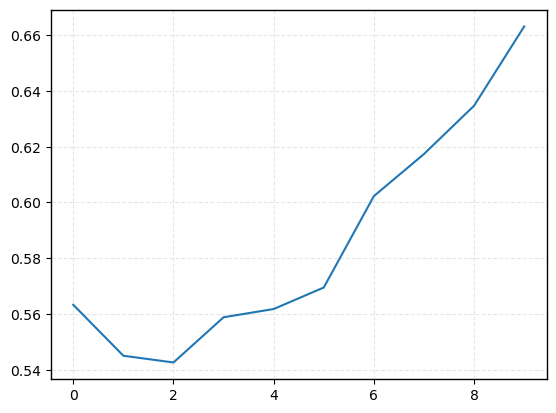

In [139]:
CRPS_Per_leadtime_stacked = np.vstack(CRPS_Per_leadtime)

plt.plot(CRPS_Per_leadtime_stacked.mean(axis = 0))

In [140]:
def compute_crps(forecasts, observation, epsilon=0.0):
    """
    Calculate the Continuous Ranked Probability Score (CRPS).
    
    Parameters:
    - forecasts: numpy array of ensemble forecasts, shape (n_members,)
    - observation: scalar true observation
    
    Returns:
    - CRPS score (lower is better)
    """
    # Sort the forecasts
    forecasts[forecasts < -0.26787253] = -0.2678724
    n_members, batch_size, num_steps = forecasts.shape
    forecasts_reshaped = forecasts.permute(1, 2, 0)


   # Reshape observations
    
    observations_expanded = observation.unsqueeze(-1)
    
    term1 = torch.abs(forecasts_reshaped - observations_expanded).mean(dim= -1)
    

    x_j = forecasts_reshaped.unsqueeze(3)  # (batch_size, num_steps, n_members, 1)

    x_k = forecasts_reshaped.unsqueeze(2)  # (batch_size, num_steps, 1, n_members)
    pairwise_diffs = torch.abs(x_j - x_k)
    term2 = pairwise_diffs.sum(dim=(2, 3))/(2* n_members * (n_members-1) )

    term1, term2  = term1.squeeze(), term2.squeeze() 
    crps_scores = term1 - ((1 - epsilon)* term2)

    return crps_scores

def calculate_overall_crps(all_ensemble_predictions, true_flow, features = ['total_flow', 'variance', 'gradient', 'autoregression'], unsqueeze = False):
    """
    Calculate CRPS for each feature across all prediction instances
    
    Parameters:
    - all_ensemble_predictions: List of dictionaries with ensemble summaries
    - true_flow: List of dictionaries with true flow values
    
    Returns:
    - Dictionary with CRPS scores for each feature
    """
    # Features to compute CRPS for
    crps_scores = {feature: [] for feature in features}
    
    # Loop through each prediction/observation pair
    for ensemble_pred, true in zip(all_ensemble_predictions, true_flow):
        for feature in features:
            # For each prediction instance and feature, compute CRPS
            forecasts = ensemble_pred[feature]
            observation = true[feature]
            # print(forecasts.shape, observation.shape)
            # Compute CRPS for this instance and feature
            if unsqueeze == True:
                forecasts, observation = forecasts.unsqueeze(-1), observation.unsqueeze(-1)
                
            crps_value = compute_crps(forecasts, observation)
            # print(crps_value.min(), crps_value.max(), crps_value.shape)
            crps_value = torch.mean(crps_value).item()
            crps_scores[feature].append(crps_value)
    
    # Compute mean CRPS for each feature
    for feature in features:
        crps_scores[feature] = np.mean(crps_scores[feature])
    
    return crps_scores

In [141]:
# Calculate CRPS for both methods
conditional_crps = calculate_overall_crps(predictions_list, discharges, ['total_flow', 'variance',  'autoregression', 'fdc_curve'], unsqueeze = True)
conditional_crps

{'total_flow': np.float64(4.449259545531589),
 'variance': np.float64(5.346875903448425),
 'autoregression': np.float64(0.2183189427828582),
 'fdc_curve': np.float64(0.04546957934198448)}

In [76]:
import random
import copy

def replace_with_random_numbers(predictions_list):
    # Create a deep copy of the original list to avoid modifying it directly
    new_list = copy.deepcopy(predictions_list)
    
    # Iterate through each dictionary in the list
    for dictionary in new_list:
        # Iterate through each key in the dictionary
        for key in dictionary:
            # Check if the value is a number (int or float)
            if isinstance(dictionary[key], (int, float)):
                # Replace with a random float between 0 and 1 (adjust range as needed)
                dictionary[key] = random.random()
                
                # If you want to preserve integers as integers:
                if isinstance(predictions_list[new_list.index(dictionary)][key], int):
                    dictionary[key] = random.randint(0, 100)  # Adjust range as needed
    
    return new_list

random_scores = replace_with_random_numbers(predictions_list)

In [62]:
def get_dispersion_calculations(ensemble_summaries, truth, interval=0.1):
    '''Returns a dataframe showing how often X% of ensemble members underpredict each statistic, 10-20%, 20-30%... 90-100%
    Parameters:
    ensemble_summaries: list of dictionaries with statistics from get_member_summaries
                       Each key contains an array of shape (num_members)
    truth: observed data statistics matching the keys in ensemble_summaries
           Should be a list of dictionares with the same keys as ensemble_summaries
    
    Returns:
    DataFrame with percentage distribution of ensemble members in each dispersion bin
    '''
    # Define bins for percentiles
    bins = torch.arange(0, 1 + interval, interval)  # 0, 0.1, 0.2, ..., 1.0
    bin_labels = [f"{int(bins[i]*100)}-{int(bins[i+1]*100)}%" for i in range(len(bins)-1)]
    
    # Initialize dictionary to store all ranks for each stat
    all_ranks = {}
    for ens_dict, truth_dict in zip(ensemble_summaries, truth):
        for stat_name in ens_dict.keys():
            ensemble_stat = torch.tensor(ens_dict[stat_name])  # shape: (num_members, num_batches)
            truth_val = truth_dict[stat_name] 
            
            # Calculate rank - mean of boolean tensor for elements smaller than truth
            rank_per_batch = torch.mean((ensemble_stat < truth_val).float(), dim=0)
            
            if stat_name not in all_ranks:
                all_ranks[stat_name] = []
            all_ranks[stat_name].extend(rank_per_batch.tolist())
    # Now compute histogram for each stat
    dispersion_results = {}
    for stat_name, ranks in all_ranks.items():
        # Convert ranks to tensor
        ranks_tensor = torch.tensor(ranks)
        
        # Calculate histogram using torch.histc
        # histc requires input to be within [min, max] range
        hist = torch.zeros(len(bins)-1)
        for i in range(len(bins)-1):
            # Count values falling in each bin manually
            hist[i] = torch.sum((ranks_tensor >= bins[i]) & (ranks_tensor < bins[i+1])).item()
            
            # Handle edge case for the last bin to include the upper bound
            if i == len(bins)-2:
                hist[i] += torch.sum(ranks_tensor == bins[i+1]).item()
        
        # Convert to percentages
        dispersion_results[stat_name] = (hist / len(ranks) * 100).tolist()
    
    return pd.DataFrame(dispersion_results, index=bin_labels)

In [ ]:
Validation_data = generate_forecast_data(Seeded_Model, Validation_Dataloader, num_forecasts=180, num_members=11, noise_scale=1, device='cpu')
predictions_list = Validation_data['predictions_list']
observations_list = Validation_data['observations_list']


In [ ]:
import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

from ML_Plots import load_and_unnormalize


In [ ]:

Seeded_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Seeded/hyperparameter_test/Seeded_lr_0.001_bi_False_h_64_64_32_0507_8_30Epochs.pth', map_location=torch.device('cpu')) # Best Seeded Model so far
Seeded_Model.eval()

Validation_data = generate_forecast_data(Seeded_Model, Validation_Dataloader, num_forecasts=180, num_members=4, noise_scale=1, device='cpu')
predictions_list = Validation_data['predictions_list']
observations_list = Validation_data['observations_list']

for j in range(20):
    predictions = predictions_list[j]
    observations = observations_list[j]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # X-axis values (days)
    days = np.arange(1, 11)
    
    # Plot each ensemble member
    for i in range(predictions.shape[0]):
        random_alpha = random.uniform(0.2, 0.7)
        plt.plot(days, predictions[i], 'b-', alpha=random_alpha, label=f'Ensemble Member' if i == 0 else None)
    
    # Plot the observations
    plt.plot(days, observations, 'r-', linewidth=2, label='Observations')
    
    # Add labels and legend
    plt.xlabel('Days')
    plt.ylabel('Value')
    plt.title('Ensemble Forecasts vs Observations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
predictions_list = []
observations_list = []
dates = [] #start of historical time series

with torch.no_grad():
    for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):
        
        if i >= num_forecasts:
            break
        Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:, 0:15]
        predictions_ensembles_list = []
        for j in range(num_ensembles):
                
            # Get prediction
            prediction = G_Model(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]
        
            # Store prediction and observation
            predictions_ensembles_list.append(prediction.squeeze().cpu().numpy())
        predictions_list.append(predictions_ensembles_list)
        observations_list.append(Y_value.squeeze().cpu().numpy())
        dates.append(date_idx)

time_index = np.arange(len(predictions_list))

In [ ]:
# Get dimensions
num_forecasts = len(predictions_list)

# Create an empty dictionary to store our data
data_dict = {}

# Initialize with an empty list for observations and each leadtime prediction
data_dict['observation'] = []

for leadtime in range(forecast_sequence_length):
    data_dict[f'prediction_leadtime_{leadtime+1}'] = []

# Create a list to store all dates that forecasts relate to
all_dates = []

# Process each forecast set
for i in range(num_forecasts):
    forecast_init_date = dates[i]
    
    # Process each leadtime in this forecast
    for leadtime in range(forecast_sequence_length):
        # Calculate the actual date this forecast is for
        forecast_date = pd.to_datetime(forecast_init_date[0]) + pd.Timedelta(days= history_sequence_length + leadtime+1)
        
        # Store this date
        all_dates.append(forecast_date)
        
        # Store the observation for this date
        data_dict['observation'].append(observations_list[i][leadtime])
        
        # Store all predictions for this date from different initialization times
        for lt in range(forecast_sequence_length):
            # Find which forecast initialization would have a prediction for this date at this leadtime
            forecast_idx = i - (lt - leadtime)
            
            # Check if that forecast exists and is within bounds
            if 0 <= forecast_idx < num_forecasts:
                # The leadtime for this forecast would be lt
                if lt < forecast_sequence_length:
                    data_dict[f'prediction_leadtime_{lt+1}'].append(predictions_list[forecast_idx][lt])
                else:
                    data_dict[f'prediction_leadtime_{lt+1}'].append(np.nan)
            else:
                data_dict[f'prediction_leadtime_{lt+1}'].append(np.nan)

# Create the DataFrame
forecasts_df = pd.DataFrame(data_dict, index=all_dates)

# Sort the DataFrame by date
forecasts_df = forecasts_df.sort_index()

# Remove duplicate dates if any (keeping the first occurrence)
forecasts_df = forecasts_df[~forecasts_df.index.duplicated(keep='first')]

print(f"Created DataFrame with {len(forecasts_df)} dates and {len(forecasts_df.columns)} columns")
print(f"Columns: {forecasts_df.columns.tolist()}")
# print(df.head())

In [ ]:
# CMAL Plots
n = 0
time_index = np.arange(len(predictions_list))

predictions_array = np.array(predictions_list)[:,n]

prediction = {
    'mu': predictions_array[:, ::4],   # mu is at indices 0 mod 4
    'b': predictions_array[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
    'tau': predictions_array[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
    'pi': predictions_array[:, 3::4],  # pi is at indices 3 mod 4
}
# Draw samples
samples = draw_from_CMAL_distribution_np(prediction, num_samples=num_samples)
quantiles = np.quantile(samples, [0.05, 0.1,0.5,0.9, 0.95], axis = 1)


q05 = quantiles[0]
q10 = quantiles[1]
q50 = quantiles[2]
q90 = quantiles[3]
q95 = quantiles[4]
# q25 = np.array([CMAL_quantile(0.25, prediction[0:3]) for prediction in predictions_array])
# q50 = np.array([CMAL_quantile(0.5, prediction[0:3]) for prediction in predictions_array])
# q75 = np.array([CMAL_quantile(0.75, prediction[0:3]) for prediction in predictions_array])



observations_array = np.array(observations_list)[:,n]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, observations_array, label='Observations', color='blue', alpha=0.7)
# plt.plot(time_index, predictions_array, label='Predictions', color='red', alpha=0.7)

plt.plot(time_index, q10, label='10h Percentile', color='orange', alpha=0.7)
plt.plot(time_index, q50, label='50th Percentile', color='red', alpha=0.7)
plt.plot(time_index, q90, label='90th Percentile', color='orange', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('River Discharge Predictions vs Observations')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate metrics
# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observations_array -  q50) ** 2) / 
           np.sum((observations_array - np.mean(q50)) ** 2))

# Kling-Gupta Efficiency (KGE)
kge = ML_functions.calculate_kge(observations_array, q50)

# R-squared (R²)
r2 = np.corrcoef(observations_array, q50)[0, 1]**2

print(f'NSE: {nse:.4f}')
print(f'KGE: {kge:.4f}')
print(f'R²: {r2:.4f}')
plt.show()

In [ ]:
from matplotlib.animation import ArtistAnimation
import matplotlib.dates as mdates
time_index = np.arange(len(predictions_list))
leadtimes = 7  # Number of leadtimes to animate

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Date")
ax.set_ylabel("River Discharge")
ax.set_title('River Discharge Predictions vs Observations (2016)')

# Create artists list for animation
artists = []

# Create a list to hold frame artists
frames = []

# First create a dummy plot with the labels for the legend
# This ensures the legend stays consistent and doesn't repeat for each frame
obs_line, = ax.plot([], [], label='Observations', color='blue', alpha=0.7)
pred_line, = ax.plot([], [], label='Predictions', color='red', alpha=0.7)

# Add legend before populating with actual data
ax.legend()
ax.grid(True, alpha=0.3)

# Format x-axis to show dates without year and rotate labels
date_fmt = mdates.DateFormatter('%b %d')  # Format: 'Month Day' (e.g., 'Jan 01')
ax.xaxis.set_major_formatter(date_fmt)

# Rotate the x-tick labels (This is the correct way)
plt.xticks(rotation=45, ha='right')


# Now create each frame
for leadtime in range(leadtimes):
    frame_artists = []
    
    # Get data for this leadtime
    predictions_array = np.array(forecasts_df[leadtimes-1:-leadtimes][f'prediction_leadtime_{leadtime + 1}'])
    observations_array = np.array(forecasts_df[leadtimes-1:-leadtimes]['observation'])
    
    # Plot the data but don't add to legend
    obs_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, observations_array, color='blue', alpha=0.7)
    pred_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, predictions_array, color='red', alpha=0.7)
    
    # Calculate metrics
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((observations_array - predictions_array) ** 2) / 
               np.sum((observations_array - np.mean(observations_array)) ** 2))
    
    # Kling-Gupta Efficiency (KGE)
    kge = ML_functions.calculate_kge(observations_array, predictions_array)
    
    # R-squared (R²)
    r2 = np.corrcoef(observations_array, predictions_array)[0, 1]**2
    
    # Add text annotations for the metrics
    leadtime_text = ax.text(0.02, 0.95, f'Leadtime: {leadtime + 1} ', transform=ax.transAxes, 
                           fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    nse_text = ax.text(0.02, 0.88, f'NSE: {nse:.4f}', transform=ax.transAxes, 
                      fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    kge_text = ax.text(0.02, 0.81, f'KGE: {kge:.4f}', transform=ax.transAxes, 
                      fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    r2_text = ax.text(0.02, 0.74, f'R²: {r2:.4f}', transform=ax.transAxes, 
                     fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    
    # Add all artists for this frame
    frame_artists.append(obs_plot)
    frame_artists.append(pred_plot)
    frame_artists.append(leadtime_text)
    frame_artists.append(nse_text)
    frame_artists.append(kge_text)
    frame_artists.append(r2_text)
    
    # Add this frame to the frames list
    frames.append(frame_artists)

# Set axis limits to fit all data
all_data = np.concatenate([
    np.array(predictions_list).flatten(),
    np.array(observations_list).flatten()
])

y_min, y_max = np.min(all_data), np.max(all_data)
margin = (y_max - y_min) * 0.05  # Add 10% margin
ax.set_ylim(y_min - margin, y_max + margin)

# For datetime x-axis, set the limits to the actual datetime range
end = 358
ax.set_xlim(forecasts_df[6:end].index[0], forecasts_df[6:end].index[-1])

# Remove the dummy lines used for legend
obs_line.remove()
pred_line.remove()

# Create animation
ani = ArtistAnimation(fig=fig, artists=frames, interval=800, repeat_delay=1000)

# Save animation
ani.save(filename="/home/mokr/Loss_Functions_Paper/Plots/Leadtimes.gif", writer="pillow")

plt.close(fig)  # Close the figure to avoid displaying it inline if in a notebook

In [ ]:
# CMAL Plots
n = 0
num_samples = 100
time_index = np.arange(len(predictions_list))

predictions_array = np.array(predictions_list)[:,n]

prediction = {
    'mu': predictions_array[:, ::4],   # mu is at indices 0 mod 4
    'b': predictions_array[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
    'tau': predictions_array[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
    'pi': predictions_array[:, 3::4],  # pi is at indices 3 mod 4
}
# Draw samples
samples = draw_from_CMAL_distribution_np(prediction, num_samples=num_samples)
quantiles = np.quantile(samples, [0.05, 0.1,0.5,0.9, 0.95], axis = 1)


q05 = quantiles[0]
q10 = quantiles[1]
q50 = quantiles[2]
q90 = quantiles[3]
q95 = quantiles[4]
q25 = np.array([CMAL_quantile(0.25, prediction[0:3]) for prediction in predictions_array])
q50 = np.array([CMAL_quantile(0.5, prediction[0:3]) for prediction in predictions_array])
q75 = np.array([CMAL_quantile(0.75, prediction[0:3]) for prediction in predictions_array])



observations_array = np.array(observations_list)[:,n]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, observations_array, label='Observations', color='blue', alpha=0.7)
# plt.plot(time_index, predictions_array, label='Predictions', color='red', alpha=0.7)

plt.plot(time_index, q10, label='10th Percentile', color='orange', alpha=0.7)
plt.plot(time_index, q50, label='50th Percentile', color='red', alpha=0.7)
plt.plot(time_index, q90, label='90th Percentile', color='orange', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('River Discharge Predictions vs Observations')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate metrics
# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observations_array -  q50) ** 2) / 
           np.sum((observations_array - np.mean(q50)) ** 2))

# Kling-Gupta Efficiency (KGE)
kge = ML_functions.calculate_kge(observations_array, q50)

# R-squared (R²)
r2 = np.corrcoef(observations_array, q50)[0, 1]**2

print(f'NSE: {nse:.4f}')
print(f'KGE: {kge:.4f}')
print(f'R²: {r2:.4f}')
plt.show()

In [ ]:
from matplotlib.animation import ArtistAnimation
import matplotlib.dates as mdates
time_index = np.arange(len(predictions_list))
leadtimes = 7  # Number of leadtimes to animate

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Date")
ax.set_ylabel("River Discharge")
ax.set_title('River Discharge Predictions vs Observations (2016)')

# Create artists list for animation
artists = []

# Create a list to hold frame artists
frames = []

# First create a dummy plot with the labels for the legend
# This ensures the legend stays consistent and doesn't repeat for each frame
obs_line, = ax.plot([], [], label='Observations', color='blue', alpha=0.7)
pred_line, = ax.plot([], [], label='Predictions', color='red', alpha=0.7)

# Add legend before populating with actual data
ax.legend()
ax.grid(True, alpha=0.3)

# Format x-axis to show dates without year and rotate labels
date_fmt = mdates.DateFormatter('%b %d')  # Format: 'Month Day' (e.g., 'Jan 01')
ax.xaxis.set_major_formatter(date_fmt)

# Rotate the x-tick labels (This is the correct way)
plt.xticks(rotation=45, ha='right')


# Now create each frame
for leadtime in range(leadtimes):
    frame_artists = []

    # Get data for this leadtime
    predictions_array = np.vstack(np.array(forecasts_df[leadtimes-1:-leadtimes][f'prediction_leadtime_{leadtime + 1}']))



    prediction = {
    'mu': predictions_array[:, ::4],   # mu is at indices 0 mod 4
    'b': predictions_array[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
    'tau': predictions_array[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
    'pi': predictions_array[:, 3::4],  # pi is at indices 3 mod 4
    }
    
    # Draw samples
    samples = draw_from_CMAL_distribution_np(prediction, num_samples=num_samples)
    quantiles = np.quantile(samples, [0.05, 0.1,0.5,0.9, 0.95], axis = 1)
    
    
    q05 = quantiles[0]
    q10 = quantiles[1]
    q50 = quantiles[2]
    q90 = quantiles[3]
    q95 = quantiles[4]
    
    observations_array = np.array(forecasts_df[leadtimes-1:-leadtimes]['observation'])
    
    # Plot the data but don't add to legend
    obs_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, observations_array, color='blue', alpha=0.7)
    # pred_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, predictions_array, color='red', alpha=0.7)
    q10_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, q10, label='10th Percentile', color='orange', alpha=0.7)
    q50_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, q50, label='50th Percentile', color='red', alpha=0.7)
    q90_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, q90, label='90th Percentile', color='orange', alpha=0.7)
    
    # Calculate metrics
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((observations_array - q10) ** 2) / 
               np.sum((observations_array - np.mean(observations_array)) ** 2))
    
    # Kling-Gupta Efficiency (KGE)
    kge = ML_functions.calculate_kge(observations_array, q10)
    
    # R-squared (R²)
    r2 = np.corrcoef(observations_array, q10)[0, 1]**2
    
    # Add text annotations for the metrics
    leadtime_text = ax.text(0.02, 0.95, f'Leadtime: {leadtime + 1} ', transform=ax.transAxes, 
                           fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    nse_text = ax.text(0.02, 0.88, f'NSE: {nse:.4f}', transform=ax.transAxes, 
                      fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    kge_text = ax.text(0.02, 0.81, f'KGE: {kge:.4f}', transform=ax.transAxes, 
                      fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    r2_text = ax.text(0.02, 0.74, f'R²: {r2:.4f}', transform=ax.transAxes, 
                     fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    
    # Add all artists for this frame
    frame_artists.append(obs_plot)
    frame_artists.append(q10_plot)
    frame_artists.append(q50_plot)
    frame_artists.append(q90_plot)
    frame_artists.append(leadtime_text)
    frame_artists.append(nse_text)
    frame_artists.append(kge_text)
    frame_artists.append(r2_text)
    
    # Add this frame to the frames list
    frames.append(frame_artists)

# Set axis limits to fit all data
all_data = np.concatenate([
    np.array(predictions_list).flatten(),
    np.array(observations_list).flatten()
])

y_min, y_max = np.min(all_data), np.max(all_data)
margin = (y_max - y_min) * 0.05  # Add 10% margin
ax.set_ylim(y_min - margin, y_max + margin)

# For datetime x-axis, set the limits to the actual datetime range
end = 358
ax.set_xlim(forecasts_df[6:end].index[0], forecasts_df[6:end].index[-1])

# Remove the dummy lines used for legend
obs_line.remove()
pred_line.remove()

# Create animation
ani = ArtistAnimation(fig=fig, artists=frames, interval=800, repeat_delay=1000)

# Save animation
ani.save(filename="/home/mokr/Loss_Functions_Paper/Plots/Leadtimes_CMAL.gif", writer="pillow")

plt.close(fig)  # Close the figure to avoid displaying it inline if in a notebook

In [ ]:
np.array(predictions_list)[:,n]

In [ ]:

np.vstack(np.array(forecasts_df[leadtimes-1:-leadtimes][f'prediction_leadtime_{leadtime + 1}'])
)

In [ ]:
forecasts_df[leadtimes-1:-leadtimes].index

In [ ]:
import gc
for i in range(1, 5): 
    loaded_traning_data4 = torch.load(f"/perm/mokr/10Day_Loss_Function_Training_Dataset{i}.pt")
    Training_Dataset4 = HydroDataset(loaded_traning_data4)

    target_date = datetime(2018, 12, 20)
    
    # Filter the list to keep only entries with dates before or on the target date
    filtered_data = []
    for item in loaded_traning_data4:
        # Access the date in the 4th position (index 3) of each tuple
        date_value = item[3]
        # print(date_value)
        # If date_value is a string, convert it to datetime object
        # You may need to adjust the format based on your actual date format
        if isinstance(date_value, str):
            # Adjust the format string to match your date format
            date_obj = datetime.strptime(date_value, '%Y-%m-%d %H:%M:%S')  # Example format
        else:
            # If it's already a datetime object
            date_obj = date_value
        
        # Keep only entries with dates before or on the target date
        if date_obj <= target_date:
            filtered_data.append(item)

    save_path = f"/perm/mokr/10Day_Loss_Function_Training_Dataset{i}_test.pt"
    torch.save(filtered_data, save_path)
    


In [ ]:
time_index = np.arange(len(predictions_list))

predictions_array = np.array(predictions_list)[:,0]
observations_array = np.array(observations_list)[:,0]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, observations_array, label='Observations', color='blue', alpha=0.7)
plt.plot(time_index, predictions_array, label='Predictions', color='red', alpha=0.7)

plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('River Discharge Predictions vs Observations')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate metrics
# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observations_array - predictions_array) ** 2) / 
           np.sum((observations_array - np.mean(predictions_array)) ** 2))

# Kling-Gupta Efficiency (KGE)
kge = ML_functions.calculate_kge(observations_array, predictions_array)

# R-squared (R²)
r2 = np.corrcoef(observations_array, predictions_array)[0, 1]**2

print(f'NSE: {nse:.4f}')
print(f'KGE: {kge:.4f}')
print(f'R²: {r2:.4f}')
plt.show()


In [ ]:

# Different from here: first indices are num_samples, batches, 7 day forecast
# Ideally I'd have different coluumns for basins and each one is a gif showing how they predictions move with time
# Convert to numpy arrays

for i in range(len(predictions_list)):
    predictions = np.array(predictions_list[i])
    observations = np.array(observations_list[i])
    
    # Create time index
    time_index = np.arange(len(predictions))
    
    # Create the plot
    plt.figure(figsize=(15, 6))
    plt.plot(time_index, observations, label='Observations', color='blue', alpha=0.7)
    plt.plot(time_index, predictions, label='Predictions', color='red', alpha=0.7)
    
    # Add bands for prediction uncertainty if available
    # plt.fill_between(time_index, predictions - std, predictions + std, 
    #                 color='red', alpha=0.2, label='Prediction Uncertainty')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('River Discharge Predictions vs Observations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calculate metrics
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((observations - predictions) ** 2) / 
               np.sum((observations - np.mean(observations)) ** 2))
    
    # Kling-Gupta Efficiency (KGE)
    kge = ML_functions.calculate_kge(observations, predictions)
    
    # R-squared (R²)
    r2 = np.corrcoef(observations, predictions)[0, 1]**2
    
    print(f'NSE: {nse:.4f}')
    print(f'KGE: {kge:.4f}')
    print(f'R²: {r2:.4f}')
    plt.show()

In [ ]:
predictions, observations = ML_functions.plot_predictions_vs_observations(LSTM_Example, eval_dataloader)

# Extra Code 

In [ ]:
# Validation_Dataset = ML_functions.Multi_Basins_HF_LSTMDataGenerator(valid_start_dates = valid_start_dates, ERA5_Land = ERA5_Land, 
#                                   HRES=HRES, Static_df = Static_df , Discharge = Discharge, scalers = scalers, basin_indices=val_basins, Hind_variables=Hind_variables, Fore_variables = Fore_variables, 
#                                   history_sequence_length=history_sequence_length, forecast_sequence_length= forecast_sequence_length)

# Training_Dataset = ML_functions.Multi_Basins_HF_LSTMDataGenerator(valid_start_dates = valid_start_dates, ERA5_Land = ERA5_Land, 
#                                   HRES=HRES, Static_df = Static_df , Discharge = Discharge, scalers = scalers, basin_indices=train_basins, Hind_variables=Hind_variables, Fore_variables = Fore_variables, 
#                                   history_sequence_length=history_sequence_length, forecast_sequence_length= forecast_sequence_length)


In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

eval_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
      

# Hindcast_Forecast dataset
'''HF_dataset = ML_functions.HF_LSTMDataGenerator(valid_start_dates = valid_start_dates, ERA5_Land = ERA5_Land, Caravans = Basin_Caravans, 
                                  HRES=HRES, Discharge=Basin_Discharge_Y, basin_index=basin_index, Hind_variables=variables, Fore_variables = Fore_variables, 
                                  history_sequence_length=90, forecast_sequence_length=7)

HF_dataloader = DataLoader(HF_dataset, batch_size=batch_size, shuffle=True)
'''
'''
MultiBasin_dataset = ML_functions.Multi_Basins_LSTMDataGenerator(
    valid_start_dates=valid_start_dates,
    ERA5_Land=ERA5_Land,
    Caravans=Basin_Caravans,
    Discharge=Basin_Discharge_Y,
    basin_indices= Suitable_Basins,
    variables=variables
)
'''


In [ ]:
shuffled_dates = valid_start_dates.sample(frac=1, random_state=42).reset_index(drop=True)
sequence_length = 90
batch_size = 2**12
average_loss = 0
# Select a random subset of start dates for the current batch




selected_dates = shuffled_dates[:batch_size]

# Loop to create batches using the selected start dates
for i, start_date in enumerate(selected_dates):
    
    # Define the end date for the current batch
    end_date = start_date + pd.Timedelta(days=sequence_length - 1)
    prediction_date = pd.Timestamp(start_date) + pd.Timedelta(days=90)

    # Select the basin-specific data
    ERA5_Land_Basin = ERA5_Land.isel(basin=basin_index)

    Basin_mean = ERA5_Land_Basin.mean()
    Basin_std = ERA5_Land_Basin.std() + 1e-5

    
    # Select the data for the current batch within the date range
    X_Chunk_xr = ERA5_Land_Basin.sel(date=slice(start_date, end_date))
    
    # Check if the selected date range is complete
    if len(X_Chunk_xr.date) < sequence_length:
        print(f"Skipping batch {i}: Incomplete date range from {start_date} to {end_date}")
        continue
    
    # Convert the selected data to a NumPy array and squeeze out singleton dimensions
    X_Chunk_np = np.array([((X_Chunk_xr[var] - Basin_mean[var]) / Basin_std[var]).values for var in variables]).squeeze()
    X_Chunk_np = X_Chunk_np.transpose()  # Shape: (sequence_length, num_variables)
    
    # Convert to a PyTorch tensor
    X_Chunk_Torch = torch.from_numpy(X_Chunk_np).float()
    
    # Placeholder for the target/output (Y_value)
    Y_value = (Basin_Discharge_Y[prediction_date] - Basin_Discharge_Y.mean() )/ Basin_Discharge_Y.std()
    target = torch.tensor(Y_value, dtype=torch.float32).unsqueeze(0)

    prediction = LSTM_Example(X_Chunk_Torch)
    

    loss = criterion(prediction, target)

    if torch.isnan(loss):
        print('Y_value is', Y_value, 'prediction date is', prediction_date, 'Prediction is', prediction)
        break
    loss.backward()
    optimizer.step()

    average_loss += loss

    
    if (i+1)%1000 == 0:
        print('loss =', average_loss)
        average_loss = 0


# Optional: Shuffle again for the next set of batches
shuffled_dates = shuffled_dates.sample(frac=1).reset_index(drop=True)

In [ ]:
# %%
ds = xr.open_zarr("/ec/res4/scratch/ecm7072/Efas/forcings_zarr_combined/forcings_daily_combined.zarr", drop_variables=['es'])
# ds = xr.open_zarr("/ec/res4/scratch/ecm7072/Glofas/forcings_zarr/forcings_combined.zarr")
ds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import xarray as xr
import zarr

import os
import itertools

import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions")
sys.path.append(str(functions_path))

import ML_functions

# Open Zarr files
ERA5_zarr_path = '/perm/mokr/Caravans_MultiMet/ERA5_LAND/timeseries.zarr'
HRES_zarr_path = '/perm/mokr/Caravans_MultiMet/HRES_Jan/HRES/timeseries.zarr'

ERA5_Land = xr.open_zarr(store=ERA5_zarr_path, chunks=None)
HRES = xr.open_zarr(store=HRES_zarr_path, chunks=None)

# Get list of viable basins ad split them to training, validation, and test sets
with open('/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Caravans_2016_2019_Basins.txt', 'r') as file:
    Suitable_Basins = file.readlines()
    # This includes newline characters at the end of each line
    Suitable_Basins = [line.strip() for line in Suitable_Basins]  # removes newline characters

Basins = set(path.split('/')[1] for path in Suitable_Basins)
Basins_List = list(Basins)

# Split into 80% training+val, 20% testing
train_val_basins, test_basins = train_test_split(Basins_List, test_size=0.2, random_state=42)
# Second split: Split the train_val set into 87.5% train, 12.5% val, so we get 70,10,20
train_basins, val_basins = train_test_split(train_val_basins, test_size=0.125, random_state=42)

## Machine Learning Section

# Making Dataloaders

import random
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from collections import defaultdict
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn


Hind_variables = list(ERA5_Land.data_vars)
Fore_variables = list(HRES.data_vars)

start_date = "2016-01-01"
end_date = "2018-12-24"
valid_start_dates = pd.Series(pd.date_range(
    start=start_date, 
    end=pd.to_datetime(end_date) - pd.Timedelta(days=90), 
    freq='D'
))

batch_size = 4
history_sequence_length = 90
forecast_sequence_length = 7


# Change Caravans to one of everything, Discharge, Basin_indices
# Basins_List insetad of indices
Training_Dataset = ML_functions.Multi_Basins_HF_LSTMDataGenerator(valid_start_dates = valid_start_dates, ERA5_Land = ERA5_Land, 
                                  HRES=HRES, basin_indices=train_basins[0:1], Hind_variables=Hind_variables, Fore_variables = Fore_variables, 
                                  history_sequence_length=history_sequence_length, forecast_sequence_length= forecast_sequence_length)

Training_Dataloader = DataLoader(Training_Dataset, batch_size=batch_size, shuffle=True)

Validation_Dataset = ML_functions.Multi_Basins_HF_LSTMDataGenerator(valid_start_dates = valid_start_dates, ERA5_Land = ERA5_Land, 
                                  HRES=HRES, basin_indices=val_basins[0:1], Hind_variables=Hind_variables, Fore_variables = Fore_variables, 
                                  history_sequence_length=history_sequence_length, forecast_sequence_length= forecast_sequence_length)

Validation_Dataloader = DataLoader(Training_Dataset, batch_size=batch_size, shuffle=True)


# Getting the model
G_Model = ML_Models.Google_Model_Block(25, 15, 8, 1, 32, 1, 'cpu')
optimizer = optim.Adam(G_Model.parameters(), lr= 1e-3)
criterion = ML_functions.KGELoss()

# Train model 
epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ML_functions.train_model(G_Model, Training_Dataloader, optimizer, criterion, epochs = epochs, train_mode = True, batch_accumulation = 200)

# Validate model
ML_functions.train_model(G_Model, Validation_Dataloader, optimizer, criterion, epochs = 1, train_mode = False, batch_accumulation = 200)

# Save model
save_path = '/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Models/G_Model_Deterministic.pth'
torch.save(G_Model, save_path)